In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49308 instead
  warnings.warn(


In [2]:
cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49360 instead
  warnings.warn(


In [3]:
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Embedding, Concatenate,BatchNormalization, Reshape
from tensorflow.keras.models import Model

In [4]:
with open('meanDict_allT.pkl', 'rb') as f:
    meanDict = pickle.load(f)

with open('stdDict_allT.pkl', 'rb') as f:
    stdDict = pickle.load(f)

In [5]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [6]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.7* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

In [7]:
targetF = ['ptend_q0002_26']
trainF = allF

val = data.partitions[sampledPartIdxTest[0:10]].compute()

In [10]:
large_ptend_q0002_26 = pd.read_csv('large_ptend_q0002_26.csv')

# train batchwise

In [6]:
tf.random.set_seed(42)

numF = len(trainF)
numT = len(targetF)

input = Input(shape=(numF))

x = BatchNormalization()(input)
#x = Dense(numF, activation='relu')(input)

print(x.shape)
for i in range(2):
    x = Dense((i+1)*numF, activation='relu')(x)
    print(x.shape)
for i in range(2):
    x = Dense(1/(i+1)*x.shape[1], activation='relu')(x)
    print(x.shape)
x = Dense(numT, activation='linear',name='output')(x)

print(x.shape)
output =x

model = Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=[RSquaredMetric()])
#model.summary()
# generate batches of data from our dask dataframe
#def dask_data_generator(df, trainPartitions, trainF, targetF, partitionsPerBatch=5):
#    n_batches = int(len(trainPartitions) / partitionsPerBatch)
#    while True:
#        randomIdx = np.random.randint(0, n_batches)
#
#        i=randomIdx
#        startIdx = i*partitionsPerBatch
#        batch = df.partitions[trainPartitions[startIdx:startIdx+partitionsPerBatch]]
#        X = batch[trainF]
#        y = batch[targetF]
#        trainData = (X.compute(), y.compute())
#        yield trainData
#
#model.fit_generator(generator=dask_data_generator(data, sampledPartIdxTrain, trainF, targetF),steps_per_epoch=3)

partitionsPerBatch=20
losses = dict()
for e in range(10):
    n_batches = int(len(sampledPartIdxTrain) / partitionsPerBatch)
    epoch = dict()
    for i in range(n_batches):
        #randomIdx = np.random.randint(0, n_batches)#
        #i=randomIdx
        startIdx = i*partitionsPerBatch
        batch = data.partitions[sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]]
        X = batch[trainF].compute()
        y = batch[targetF].compute()

        loss = model.train_on_batch(x=X, y=y, sample_weight=batch['weight_ptend_q0002_26'].compute())
        print(i, n_batches, sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch], loss)
        epoch[i] = {'loss':loss, 'partitions':sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]}
    losses[e] = epoch


(None, 556)
(None, 556)
(None, 1112)
(None, 1112)
(None, 556)
(None, 1)


2024-07-02 09:05:52,048 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:53529 -> tcp://127.0.0.1:53533
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

0 99 [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402] [2.1030992058967968e-08, -4.3009722931241083e+33]
1 99 [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569] [2.04653627378093e-08, -2.200351657068994e+37]
2 99 [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423] [0.6233018040657043, -1.4828622389234282e+23]
3 99 [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581] [9.096277722164814e-07, -2.5914818904953236e+34]
4 99 [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446] [3.088640369242057e-06, -9.411501540845084e+35]
5 99 [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293] [6.450567980209598e-06, -2.6182354662655504e+3

2024-07-02 09:11:35,745 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e248f0f57e2a42f18df633d727636d1c', 0): 'waiting'}


34 99 [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078] [2.247038310088101e-06, -1.2217992354544103e+33]
35 99 [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49] [1.4325604524856317e-06, -3.2818924394531416e+34]
36 99 [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015] [1.4023014500708086e-06, -1.2943158286744365e+35]
37 99 [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102] [1.4424275605051662e-06, -3.83663194015751e+34]
38 99 [349, 2066, 1871, 1349, 857, 1034, 657, 1726, 1778, 1117, 2738, 1116, 1556, 1748, 2801, 903, 538, 2238, 2244, 2247] [1.4447687135543674e-06, -4.528824875183891e+34]
39 99 [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473] [1.4824920526734786e-06, -2.8924092

Process Dask Worker process (from Nanny):
2024-07-02 09:16:25,787 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-07-02 09:16:25,786 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-07-02 09:16:25,793 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-07-02 09:16:25,788 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages

KeyboardInterrupt: 

In [9]:
large_ptend_q0002_26 = pd.read_csv('large_ptend_q0002_26.csv')

In [41]:
tf.random.set_seed(42)

numF = len(trainF)
numT = len(targetF)

input = Input(shape=(numF))

x = BatchNormalization()(input)
#x = Dense(numF, activation='relu')(input)

print(x.shape)
for i in range(2):
    x = Dense((i+1)*numF, activation='relu')(x)
    print(x.shape)
for i in range(2):
    x = Dense(1/(i+1)*x.shape[1], activation='relu')(x)
    print(x.shape)
x = Dense(numT, activation='linear',name='output')(x)

print(x.shape)
output =x

model = Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=[RSquaredMetric()])
#model.summary()
# generate batches of data from our dask dataframe

def my_generator(df, trainPartitions, partitionsPerBatch):
    n_batches = int(len(trainPartitions) / partitionsPerBatch)
    while True:
        indices = np.random.randint(0, len(trainPartitions), size=trainPartitions)
        batch = df.partitions[indices]
        X = batch[trainF].compute()
        y = batch[targetF].compute()
        X = pd.concat([X, large_ptend_q0002_26[trainF]], axis=0)
        y = pd.concat([y, large_ptend_q0002_26[targetF]], axis=0)

        #y_val = val[targetF]
        for f in targetF:
            y.loc[:,f] = (y[f] - meanDict[f])/ stdDict[f]
            #y_val.loc[:,f] = (val[f] - meanDict[f])/ stdDict[f]
        print(X.shape, y.shape)
        yield X, y

n_per_part = data.partitions[0].shape[0].compute()
n_part_per_batch = 10
batch_size = n_per_part*n_part_per_batch + large_ptend_q0002_26.shape[0]
train_dataset = tf.data.Dataset.from_generator(
    lambda: my_generator(data, sampledPartIdxTrain, n_part_per_batch),
    output_types=(tf.float64, tf.float64),
    output_shapes=([batch_size, len(trainF)], [batch_size, len(targetF)])
)

#train_gen = my_generator(data, sampledPartIdxTrain, n_part_per_batch)
model.fit(
    #train_gen,#
    train_dataset,
    epochs=10,
    steps_per_epoch=32 #int(len(sampledPartIdxTrain)/n_part_per_batch)
)


(None, 556)
(None, 556)
(None, 1112)
(None, 1112)
(None, 556)
(None, 1)
Epoch 1/10


2024-07-03 08:48:12.539633: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: maximum supported dimension for an ndarray is 32, found 1987
Traceback (most recent call last):

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3963/1047057521.py", line 31, in my_generator
    indices = np.random.randint(0, len(trainPartitions), size=trainPartitions)

  File "numpy/random/mtrand.pyx", line 782, in numpy.

InvalidArgumentError: Graph execution error:

ValueError: maximum supported dimension for an ndarray is 32, found 1987
Traceback (most recent call last):

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3963/1047057521.py", line 31, in my_generator
    indices = np.random.randint(0, len(trainPartitions), size=trainPartitions)

  File "numpy/random/mtrand.pyx", line 782, in numpy.random.mtrand.RandomState.randint

  File "numpy/random/_bounded_integers.pyx", line 1316, in numpy.random._bounded_integers._rand_int64

ValueError: maximum supported dimension for an ndarray is 32, found 1987


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_24950]

# add significant values to each batch

- without sampling: seems like results are better than before, but still can't fit target well

In [7]:
large_ptend_q0002_26 = pd.read_csv('large_ptend_q0002_26.csv')

In [11]:
tf.random.set_seed(42)

numF = len(trainF)
numT = len(targetF)

input = Input(shape=(numF))

x = BatchNormalization()(input)
#x = Dense(numF, activation='relu')(input)

print(x.shape)
for i in range(2):
    x = Dense((i+1)*numF, activation='relu')(x)
    print(x.shape)
for i in range(2):
    x = Dense(1/(i+1)*x.shape[1], activation='relu')(x)
    print(x.shape)
x = Dense(numT, activation='linear',name='output')(x)

print(x.shape)
output =x

model = Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=[RSquaredMetric()])

partitionsPerBatch=20
losses = dict()
for e in range(10):
    n_batches = int(len(sampledPartIdxTrain) / partitionsPerBatch)
    epoch = dict()
    for i in range(n_batches):
        #randomIdx = np.random.randint(0, n_batches)#
        #i=randomIdx
        startIdx = i*partitionsPerBatch
        batch = data.partitions[sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]]
        X = batch[trainF].compute()
        y = batch[targetF].compute()
        X = pd.concat([X, large_ptend_q0002_26[trainF]], axis=0)
        y = pd.concat([y, large_ptend_q0002_26[targetF]], axis=0)


        lossT = model.train_on_batch(x=X, y=y)#, sample_weight=batch['weight_ptend_q0002_26'].compute())
        lossV = model.test_on_batch(x=val[trainF], y=val[targetF])
        print(i, n_batches, lossT, lossV, sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch])
        epoch[i] = {'lossT':lossT,'lossV':lossV, 'partitions':sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]}
    losses[e] = epoch


(None, 556)
(None, 556)
(None, 1112)
(None, 1112)
(None, 556)
(None, 1)


Task exception was never retrieved
future: <Task finished name='Task-54436' coro=<Client._gather.<locals>.wait() done, defined at /Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


0 99 [0.013486918993294239, -1.326832930029851e+21] [42996.05859375, -3.9578910291228837e+36] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [3.697033166885376, -3.6364210707691715e+23] [936.6128540039062, -8.621747294086645e+34] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]
2 99 [2.1725940704345703, -2.0385914809901845e+23] [532.7128295898438, -4.9037503665379555e+34] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [0.35540640354156494, -3.4965564700936204e+22] [28.312942504882812, -2.606274778788768e+33] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [0.005525982938706875, -5.433389936595551e+20] [38.58668899536133, -3.551997833860795e+33] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1

2024-07-02 09:41:03,408 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5b591424783b3a02c8bd6d294719cfb6', 0): 'waiting'}


9 99 [0.02837420254945755, -2.7895352386928194e+21] [42.193389892578125, -3.88400375836183e+33] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [0.024664033204317093, -2.425736431118668e+21] [8.094685554504395, -7.451353750877318e+32] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]
11 99 [0.00642557255923748, -6.318422206086403e+20] [0.7802697420120239, -7.182571145692955e+31] [594, 543, 410, 70, 879, 2563, 486, 1204, 56, 1418, 1960, 2318, 2737, 1591, 321, 102, 393, 2341, 1417, 485]
12 99 [0.0008063071873039007, -7.929153612376388e+19] [9.845142364501953, -9.062691323074774e+32] [2559, 1729, 2022, 1064, 2505, 2530, 2428, 124, 420, 1941, 528, 598, 1904, 1845, 662, 2004, 727, 2054, 1588, 2321]
13 99 [0.007124708499759436, -7.008377187436771e+20] [14.634464263916016, -1.3471378016957142e+33] [1091, 1655, 2180, 2398, 1357, 1225, 233, 1475, 1740, 2709, 1014, 

2024-07-02 09:49:07,139 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4969c691f0f8b561f13bbc638e1bb234', 0): 'waiting'}


55 99 [0.00014544987061526626, -1.430088374857551e+19] [0.005014658905565739, -4.616114748162353e+29] [2138, 2591, 2702, 2594, 382, 1421, 2071, 1226, 552, 222, 1096, 2462, 8, 1530, 316, 427, 1207, 105, 1506, 2705]
56 99 [6.727288564434275e-05, -6.617266145990803e+18] [0.021823851391673088, -2.0089382231422532e+30] [121, 2013, 2715, 1711, 2325, 115, 1272, 2245, 2019, 2653, 2792, 2579, 1614, 672, 1453, 2805, 591, 1269, 888, 1575]
57 99 [4.934280150337145e-05, -4.853581875072991e+18] [0.044864557683467865, -4.1298909792581744e+30] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [8.326195529662073e-05, -8.187461659187479e+18] [0.05970672890543938, -5.496148520657636e+30] [1815, 2102, 2820, 2597, 2164, 1565, 205, 733, 526, 1244, 898, 377, 1553, 2539, 2443, 386, 198, 1050, 590, 519]
59 99 [0.00012447297922335565, -1.2241061963634835e+19] [0.05701272189617157, -5.248158544965538e+30] [1833, 429, 1083, 207, 491, 2759, 792, 

2024-07-02 09:51:51,122 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ee9ec5c6d5b860fd29b3f8c3052692e6', 0): 'waiting'}


70 99 [6.865522300358862e-05, -6.755627039962694e+18] [0.029559355229139328, -2.721010038005105e+30] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]


2024-07-02 09:52:04,901 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0f2a4722dd884ad2c47ca43134d7bab4', 0): 'waiting'}
2024-07-02 09:52:06,698 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0f2a4722dd884ad2c47ca43134d7bab4', 0): 'waiting'}


71 99 [6.500133167719468e-05, -6.390956416424739e+18] [0.02288697473704815, -2.1068013727029672e+30] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]
72 99 [4.887238173978403e-05, -4.807374349159891e+18] [0.014879018999636173, -1.3696496361335725e+30] [1798, 182, 985, 1793, 1194, 2650, 1507, 1121, 187, 619, 1456, 1175, 1876, 2080, 614, 1936, 994, 934, 371, 2060]
73 99 [4.13406960433349e-05, -4.064246600661205e+18] [0.00888190045952797, -8.176004608142875e+29] [2050, 593, 726, 826, 687, 2095, 136, 628, 334, 1909, 2183, 1109, 1561, 2555, 710, 1039, 2002, 2740, 1880, 2614]
74 99 [4.2970666982000694e-05, -4.230065598513545e+18] [0.005743797868490219, -5.2873046963726154e+29] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]
75 99 [5.314411464496516e-05, -5.225576895319376e+18] [0.0050828540697693825, -4.6788901102924355e+29] [865, 101, 1501, 2029, 1995, 107, 1677,

2024-07-02 09:54:40,021 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0c246ae38aafd8027e57bb5e1932201', 0): 'waiting'}


85 99 [3.703628681250848e-05, -3.644988798216962e+18] [0.005551726091653109, -5.11049816188602e+29] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]
86 99 [4.22533048549667e-05, -4.1540222748249293e+18] [0.005685084033757448, -5.2332574008708316e+29] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [4.0303144487552345e-05, -3.9647237559172465e+18] [0.0067859613336622715, -6.246641358109388e+29] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]
88 99 [3.544769060681574e-05, -3.487744066915926e+18] [0.008573586121201515, -7.892193404836958e+29] [2673, 1203, 24, 2666, 2544, 1971, 2173, 875, 2552, 938, 2554, 1552, 346, 2376, 2813, 1854, 385, 2046, 2377, 2077]
89 99 [3.284458944108337e-05, -3.2320608842138255e+18] [0.01042362954467535, -9.595202673456263e+29] [243, 1924, 936, 1689, 2444, 312, 1459, 

2024-07-02 09:57:27,218 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-30299e38c7887a480d1a1c898f9703f3', 0): 'waiting'}


1 99 [2.9908076612628065e-05, -2.9417741464402657e+18] [0.007907276973128319, -7.278838845626378e+29] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]
2 99 [3.1160874641500413e-05, -2.92389141444821e+18] [0.007762940600514412, -7.145974120157544e+29] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [3.236137126805261e-05, -3.183773906934694e+18] [0.0071326689794659615, -6.565793996594463e+29] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [3.07282134599518e-05, -3.0213331585586954e+18] [0.006282416172325611, -5.783115775931384e+29] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [3.0408364182221703e-05, -2.9902911965275095e+18] [0.005498103331774473, -5.0611369650925174e+29] [941, 840, 1005, 318, 1807, 2733, 1151

2024-07-02 10:01:22,127 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-73babe4539d62bc7685491004873d38f', 0): 'waiting'}


22 99 [2.7777254217653535e-05, -2.7320739144012923e+18] [0.004569774027913809, -4.206587348874711e+29] [2260, 1830, 1360, 1058, 2370, 557, 1640, 2073, 226, 231, 1547, 251, 111, 51, 1580, 1885, 952, 554, 1431, 2008]
23 99 [2.6953857741318643e-05, -2.652493461806121e+18] [0.004359917249530554, -4.013409314265303e+29] [912, 2188, 2279, 1001, 1448, 464, 1606, 655, 2628, 2442, 2522, 2090, 1380, 1775, 212, 1993, 2826, 2679, 422, 2367]
24 99 [2.7972699172096327e-05, -2.7498752825328927e+18] [0.00420945230871439, -3.874902683112055e+29] [313, 2623, 2166, 1718, 2412, 874, 2500, 1251, 218, 1025, 1846, 1670, 1877, 1299, 2440, 695, 2093, 781, 2534, 2503]
25 99 [2.6485380658414215e-05, -2.604159480404902e+18] [0.004030672367662191, -3.710331233498597e+29] [1435, 2674, 2230, 2402, 1868, 958, 1956, 2810, 1562, 2736, 1286, 788, 1716, 809, 2755, 358, 764, 259, 1858, 2414]
26 99 [2.6996283850166947e-05, -2.655982487078961e+18] [0.003913732711225748, -3.602685456205561e+29] [685, 1978, 2280, 1878, 1339, 

2024-07-02 10:02:45,402 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-49a265585393fb8a3da2d5aa0000db94', 0): 'waiting'}


29 99 [2.5951474526664242e-05, -2.5508650522949714e+18] [0.003820717101916671, -3.517062529452718e+29] [157, 1723, 1510, 700, 238, 2582, 1381, 1780, 100, 315, 807, 829, 612, 2603, 261, 729, 1973, 1886, 1948, 179]
30 99 [2.6205769245279953e-05, -2.5770172112395305e+18] [0.003808842971920967, -3.506131951096808e+29] [1010, 1377, 1210, 1813, 889, 480, 1350, 2306, 1847, 1187, 1879, 2286, 1532, 746, 1601, 1721, 2063, 1313, 247, 2535]
31 99 [2.6078836526721716e-05, -2.5658255572583055e+18] [0.003732323180884123, -3.435693888216962e+29] [1914, 347, 842, 1602, 2154, 1110, 2486, 1583, 1536, 445, 617, 1702, 1097, 1472, 1767, 1413, 2416, 547, 1593, 263]


2024-07-02 10:03:22,416 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6d062c3fe95a19f9b0f52cc26f4dd818', 0): 'waiting'}
2024-07-02 10:03:24,298 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6d062c3fe95a19f9b0f52cc26f4dd818', 0): 'waiting'}


32 99 [2.668807610461954e-05, -2.6223044459201823e+18] [0.003590454114601016, -3.305099676553092e+29] [1125, 1674, 353, 208, 1713, 1368, 2779, 2184, 2330, 57, 2215, 2543, 561, 229, 2358, 2812, 817, 2051, 900, 2722]
33 99 [2.611338277347386e-05, -2.5687705991533036e+18] [0.003425779053941369, -3.153512279136954e+29] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]
34 99 [2.616724304971285e-05, -2.5764135793558815e+18] [0.003317605471238494, -3.053936081689846e+29] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [2.669563764357008e-05, -2.62536823507098e+18] [0.0032833160366863012, -3.0223717841183453e+29] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [2.5136956537608057e-05, -2.473459433699541e+18] [0.003269013250246644, -3.0092058263641047e+29] [1338, 803, 2835, 48, 719, 1057, 1822, 2

2024-07-02 10:04:44,516 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9ffa4a019a248148d842c1950569d695', 0): 'waiting'}
2024-07-02 10:04:46,500 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9ffa4a019a248148d842c1950569d695', 0): 'waiting'}


39 99 [2.5315044695162214e-05, -2.4922019837845176e+18] [0.0031712022610008717, -2.9191682425284155e+29] [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473]
40 99 [2.5494557121419348e-05, -2.5067031677653484e+18] [0.0031173531897366047, -2.869598883820348e+29] [782, 2366, 299, 1326, 1075, 1196, 1037, 1921, 2310, 220, 1467, 2033, 449, 2683, 1041, 84, 1345, 2177, 621, 266]
41 99 [2.4833894713083282e-05, -2.4412464917847736e+18] [0.0030396748334169388, -2.798094132799351e+29] [1124, 290, 2421, 1609, 1023, 416, 472, 1450, 1829, 2796, 1474, 2342, 2751, 654, 1949, 1940, 1397, 821, 343, 2609]
42 99 [2.4511544324923307e-05, -2.4129937158753485e+18] [0.0029946628492325544, -2.756659522594675e+29] [2830, 1259, 278, 2328, 1461, 1521, 1316, 18, 613, 643, 1596, 2117, 1027, 2824, 1395, 2672, 2610, 2464, 945, 1053]
43 99 [2.5181225282722153e-05, -2.475996556780634e+18] [0.00296127051115036, -2.7259210724736984e+29] [1292, 1894, 1937, 680,

2024-07-02 10:07:56,619 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:56767 -> tcp://127.0.0.1:51245
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

56 99 [2.3381329810945317e-05, -2.299893826673705e+18] [0.002264787210151553, -2.0847912536628128e+29] [121, 2013, 2715, 1711, 2325, 115, 1272, 2245, 2019, 2653, 2792, 2579, 1614, 672, 1453, 2805, 591, 1269, 888, 1575]
57 99 [2.289344229211565e-05, -2.251902892900352e+18] [0.0021955659613013268, -2.0210716071308154e+29] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [2.282237255712971e-05, -2.2442097474797568e+18] [0.002131345681846142, -1.9619553234463194e+29] [1815, 2102, 2820, 2597, 2164, 1565, 205, 733, 526, 1244, 898, 377, 1553, 2539, 2443, 386, 198, 1050, 590, 519]


2024-07-02 10:08:32,114 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-1764ebe8e954f4899c0fb75d94b41782', 0): 'waiting'}


59 99 [2.237178705399856e-05, -2.2001116346245448e+18] [0.0020786814857274294, -1.913476453606476e+29] [1833, 429, 1083, 207, 491, 2759, 792, 1818, 1186, 1185, 2233, 1213, 83, 2241, 2271, 20, 1253, 1410, 1747, 2550]
60 99 [2.3379583581117913e-05, -2.298252118374482e+18] [0.0020534791983664036, -1.8902771671280714e+29] [1746, 973, 2645, 883, 1098, 1896, 2151, 886, 2693, 2347, 1366, 2401, 2159, 2508, 458, 2566, 78, 2761, 1056, 906]


2024-07-02 10:08:56,607 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}
2024-07-02 10:08:58,512 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}
2024-07-02 10:09:00,797 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}


61 99 [2.2978952983976342e-05, -2.258592871399555e+18] [0.002018291736021638, -1.8578862665274092e+29] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [2.3652239178773016e-05, -2.3285663411470336e+18] [0.0019685078877955675, -1.812059099915027e+29] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [2.2751330106984824e-05, -2.2385021826199716e+18] [0.0019289085175842047, -1.7756067752444376e+29] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]
64 99 [2.1659523554262705e-05, -2.1292541575283343e+18] [0.0018795758951455355, -1.7301949879878885e+29] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]
65 99 [2.2610976884607226e-05, -2.223815868368814e+18] [0.0018392741912975907, -1.693096265793124e+29] [2507, 1285, 1738, 1309

2024-07-02 10:11:08,105 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-aa3f1b49b41aaea2f98055da53601dec', 0): 'waiting'}


72 99 [2.1551948520937003e-05, -2.1199762035352535e+18] [0.0015130474930629134, -1.3927967310176086e+29] [1798, 182, 985, 1793, 1194, 2650, 1507, 1121, 187, 619, 1456, 1175, 1876, 2080, 614, 1936, 994, 934, 371, 2060]


2024-07-02 10:11:21,200 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-10ff5f75e6ce1259ab2a86a687001db3', 0): 'waiting'}


73 99 [2.1784950149594806e-05, -2.141701041471619e+18] [0.0014935514191165566, -1.3748501327780998e+29] [2050, 593, 726, 826, 687, 2095, 136, 628, 334, 1909, 2183, 1109, 1561, 2555, 710, 1039, 2002, 2740, 1880, 2614]
74 99 [2.16279204323655e-05, -2.1290693021359145e+18] [0.0014920913381502032, -1.3735060528297454e+29] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]
75 99 [2.2436166545958258e-05, -2.2061127690889462e+18] [0.0014884781558066607, -1.3701800901158603e+29] [865, 101, 1501, 2029, 1995, 107, 1677, 2827, 1913, 1762, 1584, 1769, 2129, 2213, 2773, 2788, 712, 72, 2163, 2425]
76 99 [2.1763138647656888e-05, -2.1401677725066854e+18] [0.0014672650722786784, -1.350652915814535e+29] [2732, 481, 2098, 1835, 1514, 2802, 1490, 1171, 2322, 2196, 2096, 2268, 405, 757, 1763, 2069, 1691, 97, 1333, 2261]
77 99 [2.0910443708999082e-05, -2.055335777499349e+18] [0.0014232862740755081, -1.3101693902195088e+29] [743, 806, 2626, 18

2024-07-02 10:12:21,401 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e1eb119940b616bdcd8404864545fbc7', 0): 'waiting'}


78 99 [2.1343645130400546e-05, -2.098173025395409e+18] [0.0013687203172594309, -1.2599401280191251e+29] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]
79 99 [2.1143701815162785e-05, -2.0804126140719432e+18] [0.0013312040828168392, -1.225405556377229e+29] [33, 1626, 2240, 1379, 41, 1610, 2312, 2469, 1777, 2281, 609, 1132, 28, 441, 1752, 2045, 493, 1258, 1301, 2681]


2024-07-02 10:12:46,800 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c8b602aaaf896a1bce6c5cb1ff8dc7a1', 0): 'waiting'}


80 99 [2.2159005311550573e-05, -2.1791267680136724e+18] [0.001313848071731627, -1.2094289405397141e+29] [1382, 1304, 236, 551, 520, 2097, 1232, 1138, 720, 735, 2512, 58, 631, 1181, 2083, 592, 1303, 1387, 2478, 2491]
81 99 [2.1468515114975162e-05, -2.1122574944693125e+18] [0.0013005249202251434, -1.197164576994383e+29] [2646, 939, 2644, 1249, 904, 1279, 2274, 2726, 2665, 2259, 1839, 1142, 2782, 706, 2502, 1022, 745, 1546, 2229, 2615]


2024-07-02 10:13:12,099 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-62a4beacccc14dd6f04480eaa064913e', 0): 'waiting'}


82 99 [2.0702858819277026e-05, -2.035679395812737e+18] [0.0012853167718276381, -1.1831652160032456e+29] [513, 81, 2607, 1308, 2364, 914, 1404, 1647, 2617, 1108, 150, 774, 329, 6, 943, 822, 734, 909, 468, 181]
83 99 [2.184704499086365e-05, -2.147484197755814e+18] [0.0012435723328962922, -1.1447383754588387e+29] [164, 1905, 451, 490, 1805, 1143, 1311, 2121, 1111, 2706, 1441, 2498, 1918, 1627, 1632, 1074, 1910, 1954, 2316, 2419]
84 99 [2.130729080818128e-05, -2.0952830965207532e+18] [0.0011960584670305252, -1.101000667120467e+29] [2176, 327, 442, 2110, 2406, 832, 2246, 2282, 1414, 1201, 1499, 2262, 86, 1403, 2772, 1481, 777, 2630, 1666, 54]


2024-07-02 10:13:50,308 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0c246ae38aafd8027e57bb5e1932201', 0): 'waiting'}
2024-07-02 10:13:55,699 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0c246ae38aafd8027e57bb5e1932201', 0): 'waiting'}


85 99 [2.0183639207971282e-05, -1.9864069812372111e+18] [0.0011643603211268783, -1.071821825754123e+29] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]
86 99 [2.1515785192605108e-05, -2.1152678198672097e+18] [0.0011467464501038194, -1.0556077693298494e+29] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [2.129799031536095e-05, -2.0951378235469332e+18] [0.0011276381555944681, -1.0380181819964456e+29] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]
88 99 [2.0133702491875738e-05, -1.98098102879309e+18] [0.001121186651289463, -1.0320793339075887e+29] [2673, 1203, 24, 2666, 2544, 1971, 2173, 875, 2552, 938, 2554, 1552, 346, 2376, 2813, 1854, 385, 2046, 2377, 2077]
89 99 [2.040636354649905e-05, -2.008081516516606e+18] [0.0011156406253576279, -1.0269741723976176e+29] [243, 1924, 936, 1689, 2444, 3

2024-07-02 10:14:57,402 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-dcefb52bfa736691f64a83b922fd51d0', 0): 'waiting'}


90 99 [1.9701486962730996e-05, -1.938981746196349e+18] [0.001091678161174059, -1.0049160930034632e+29] [1897, 1645, 2446, 2124, 1987, 813, 1792, 1430, 778, 1749, 1320, 1963, 2720, 1052, 2194, 1013, 1401, 2126, 2362, 2493]
91 99 [2.0039540686411783e-05, -1.9708583749919703e+18] [0.0010387387592345476, -9.561841043201382e+28] [126, 887, 2357, 1347, 1007, 355, 1003, 1483, 682, 827, 2119, 2350, 1922, 984, 1233, 2417, 1915, 140, 217, 2334]
92 99 [2.0189063434372656e-05, -1.9851587606617784e+18] [0.0009951838292181492, -9.160908350912562e+28] [362, 2523, 345, 2148, 22, 711, 1157, 2506, 871, 2134, 10, 2287, 2147, 2678, 1834, 793, 1315, 754, 626, 94]
93 99 [2.027371374424547e-05, -1.9934008372625408e+18] [0.0009663004893809557, -8.895029673194036e+28] [2108, 129, 1708, 843, 323, 2459, 1869, 1284, 1671, 2753, 14, 2136, 947, 215, 227, 2651, 1182, 805, 2023, 864]


2024-07-02 10:15:48,902 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c2f7f64e45641c1ce78db16886b6126f', 0): 'waiting'}


94 99 [2.0712537661893293e-05, -2.0388473636902666e+18] [0.0009565689833834767, -8.805449214433888e+28] [1865, 1658, 516, 1545, 1857, 597, 195, 1277, 288, 950, 2671, 2423, 2707, 1120, 2035, 549, 156, 419, 922, 2079]
95 99 [1.965690535143949e-05, -1.9333848196941087e+18] [0.0009544340427964926, -8.785795669605481e+28] [477, 2752, 1692, 2092, 2712, 1523, 1471, 553, 1202, 390, 578, 1669, 2631, 2380, 2577, 1639, 820, 2717, 1006, 1248]


2024-07-02 10:16:17,504 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5b72e8dd7a89de95ae190f1d1028937e', 0): 'waiting'}


96 99 [1.986489223781973e-05, -1.953310031973712e+18] [0.0009415432577952743, -8.66713298909723e+28] [144, 664, 2519, 142, 2476, 1046, 1888, 421, 1660, 1714, 799, 2256, 615, 1318, 1957, 295, 401, 88, 2329, 1772]
97 99 [1.9971799702034332e-05, -1.9631277087370772e+18] [0.000904808402992785, -8.32897943683168e+28] [2795, 131, 2756, 2024, 77, 1402, 2338, 2465, 1188, 724, 1314, 2225, 1851, 269, 2170, 2355, 2216, 2731, 1372, 1855]


2024-07-02 10:16:44,901 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e439dedca7df2a65d2328daa3026463c', 0): 'waiting'}


98 99 [1.9222394257667474e-05, -1.8897478145277952e+18] [0.0008557888213545084, -7.877743152294036e+28] [2466, 917, 1343, 1319, 2436, 2723, 587, 1953, 2590, 2829, 375, 1908, 333, 2130, 2175, 2669, 1604, 1840, 1118, 2040]
0 99 [1.9537714251782745e-05, -1.922105617099522e+18] [0.0008165587787516415, -7.516620953929105e+28] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [1.8997297956957482e-05, -1.8685841398384558e+18] [0.0007959689828567207, -7.32708641395589e+28] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]


2024-07-02 10:17:27,103 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-466d71876f21084b8e93ad4b571f4d79', 0): 'waiting'}
2024-07-02 10:17:29,316 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-466d71876f21084b8e93ad4b571f4d79', 0): 'waiting'}


2 99 [1.954770414158702e-05, -1.8342029609937142e+18] [0.0007886554813012481, -7.2597643573761e+28] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [1.9556095139705576e-05, -1.9239661282126725e+18] [0.000779292022343725, -7.173571252094115e+28] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [1.9329194401507266e-05, -1.9005315496951153e+18] [0.000764707918278873, -7.039321456535856e+28] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [1.9353288735146634e-05, -1.9031595199244534e+18] [0.0007348490180447698, -6.764462726713504e+28] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [1.919165879371576e-05, -1.8885229585744527e+18] [0.0007032006396912038, -6.473131438125606e+28] [2248, 862, 1817, 644, 30, 439, 2

2024-07-02 10:18:38,103 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}


7 99 [1.95841676031705e-05, -1.9257587444828078e+18] [0.0006791489431634545, -6.251729896889339e+28] [2396, 1947, 73, 1783, 63, 1356, 211, 45, 2337, 2144, 1451, 1436, 80, 1149, 2713, 1487, 976, 479, 2431, 1411]
8 99 [1.949488250829745e-05, -1.9193260517045043e+18] [0.0006651772418990731, -6.123117662438329e+28] [1945, 408, 2084, 1061, 1466, 691, 2670, 2127, 1029, 2719, 2005, 599, 2057, 1786, 1607, 610, 44, 1406, 460, 2786]
9 99 [1.9489112673909403e-05, -1.9160209197514097e+18] [0.000658229342661798, -6.059160291977584e+28] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [1.909816637635231e-05, -1.878326912372179e+18] [0.0006558917812071741, -6.03764235686174e+28] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]
11 99 [1.9353023162693717e-05, -1.9030297775523758e+18] [0.000642063096165657, -5.910345773712858e+28] [594, 543, 410, 70, 879, 2563, 486, 1204, 5

2024-07-02 10:20:03,302 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-230e090ee377cab974821a59194b0c82', 0): 'waiting'}


13 99 [1.840277764131315e-05, -1.810230034095407e+18] [0.0005990999634377658, -5.514860331162029e+28] [1091, 1655, 2180, 2398, 1357, 1225, 233, 1475, 1740, 2709, 1014, 1260, 509, 1842, 869, 1624, 1789, 1374, 2346, 2748]
14 99 [1.8574492059997283e-05, -1.8265742744422973e+18] [0.0005895196227356791, -5.426670609331086e+28] [2179, 1047, 2730, 1242, 1100, 1801, 2828, 1235, 29, 1844, 847, 2430, 1933, 2231, 1700, 188, 170, 2587, 43, 87]


2024-07-02 10:20:33,701 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-abb957577d927e7d569812ce9dc17911', 0): 'waiting'}


15 99 [1.8479224308975972e-05, -1.8185158162833736e+18] [0.0005838592769578099, -5.374565434269048e+28] [2546, 834, 282, 1355, 2667, 642, 964, 2415, 1099, 2323, 149, 521, 1503, 2302, 2689, 2447, 916, 134, 2822, 676]
16 99 [1.8817436284734868e-05, -1.851094208375423e+18] [0.0005769535782746971, -5.310997186806491e+28] [1177, 322, 1385, 1717, 1261, 1567, 1048, 2445, 221, 1727, 1739, 1703, 173, 1174, 1644, 471, 1264, 2285, 511, 2838]
17 99 [1.895661625894718e-05, -1.865571615417303e+18] [0.0005617022980004549, -5.170605481400611e+28] [314, 152, 678, 272, 270, 1849, 2809, 867, 1173, 670, 2195, 2107, 2458, 257, 1939, 2016, 1278, 2289, 567, 254]
18 99 [1.884917583083734e-05, -1.8533340510001562e+18] [0.0005419529043138027, -4.9888071221996335e+28] [693, 1427, 930, 168, 2181, 2227, 783, 291, 2020, 2492, 1265, 1618, 135, 1831, 2113, 1656, 367, 1106, 1321, 1710]


2024-07-02 10:21:33,702 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b857cee8aa25073f993364ec44e848c3', 0): 'waiting'}


19 99 [1.8188671674579382e-05, -1.7902635901297623e+18] [0.0005213250406086445, -4.7989231271066865e+28] [707, 1477, 1068, 2111, 2790, 1011, 785, 2222, 210, 2007, 1874, 365, 1712, 478, 443, 1743, 1429, 998, 2250, 108]


2024-07-02 10:21:51,003 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-812ab7e0f0dcfc7830bc6c8230eb89c1', 0): 'waiting'}


20 99 [1.8894665117841214e-05, -1.859500112208724e+18] [0.00050211331108585, -4.622074752453053e+28] [744, 2472, 407, 414, 332, 907, 535, 1088, 2172, 2426, 838, 798, 2273, 506, 199, 2404, 1770, 289, 246, 2356]
21 99 [1.8241220459458418e-05, -1.7934352688590356e+18] [0.0004918958875350654, -4.528020795923683e+28] [978, 736, 2116, 605, 1463, 2525, 96, 1220, 2114, 2452, 2242, 1564, 1407, 2714, 2451, 1376, 1241, 104, 2654, 1832]
22 99 [1.8951172023662366e-05, -1.863971276243075e+18] [0.0004890419659204781, -4.501749326706183e+28] [2260, 1830, 1360, 1058, 2370, 557, 1640, 2073, 226, 231, 1547, 251, 111, 51, 1580, 1885, 952, 554, 1431, 2008]
23 99 [1.81726245500613e-05, -1.7883438428276654e+18] [0.0004848411481361836, -4.4630802287612045e+28] [912, 2188, 2279, 1001, 1448, 464, 1606, 655, 2628, 2442, 2522, 2090, 1380, 1775, 212, 1993, 2826, 2679, 422, 2367]
24 99 [1.8965467461384833e-05, -1.8644131424784876e+18] [0.00047673191875219345, -4.388432365056539e+28] [313, 2623, 2166, 1718, 2412, 87

2024-07-02 10:23:11,102 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6b3f607ddce10a52d4ca97fdbee7085a', 0): 'waiting'}


25 99 [1.812708615034353e-05, -1.7823350117818696e+18] [0.000457114219898358, -4.2078467095683625e+28] [1435, 2674, 2230, 2402, 1868, 958, 1956, 2810, 1562, 2736, 1286, 788, 1716, 809, 2755, 358, 764, 259, 1858, 2414]
26 99 [1.8340497263125144e-05, -1.8043980869827297e+18] [0.00043343714787624776, -3.989893440337887e+28] [685, 1978, 2280, 1878, 1339, 1791, 2573, 2605, 456, 462, 2103, 565, 381, 761, 2354, 962, 1113, 1525, 1200, 2837]


Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-07-02 10:23:48,822 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-07-02 10:23:48,822 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-07-02 10:23:48,822 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/Users/

KeyboardInterrupt: 

# try to batchwise update + zscore transformed target
- zscore helps against big r score values from beginning on (todo: check transformed back values)
- doesn't really work

In [14]:
class RSquaredMetricZScore(tf.keras.metrics.Metric):
    def __init__(self, mean, std,name='r_squaredZScoreCorr',  **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_sum_squares = None#self.add_weight(name='total_sum_squares', initializer='zeros', shape=shape)
        self.residual_sum_squares = None#self.add_weight(name='residual_sum_squares', initializer='zeros', shape=shape)
        self.num_samples = self.add_weight(name="num_samples", initializer='zeros',dtype=tf.int64)
        self.mean = self.add_weight(name="mean", initializer=tf.constant_initializer(mean))
        self.std = self.add_weight(name="std", initializer=tf.constant_initializer(std))
 
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        y_true = y_true * self.std + self.mean 
        y_pred = y_pred * self.std + self.mean 
        
        sum_squares_residuals = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        sum_squares_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        sum_squares_total = tf.where(tf.equal(sum_squares_total, 0.0), tf.ones_like(sum_squares_total), sum_squares_total)
        
        if self.total_sum_squares is None:
            self.total_sum_squares = self.add_weight(name='total_sum_squares', initializer='zeros', shape=sum_squares_total.shape)
            self.residual_sum_squares = self.add_weight(name='residual_sum_squares', initializer='zeros', shape=sum_squares_residuals.shape)

        self.total_sum_squares.assign_add(sum_squares_total)
        self.residual_sum_squares.assign_add(sum_squares_residuals)
    def result(self):
        r_squared = 1 - (self.residual_sum_squares / self.total_sum_squares)
        r_squared = tf.where(tf.math.is_nan(r_squared), tf.ones_like(r_squared), r_squared)
        return tf.reduce_mean(r_squared)

    def reset_state(self):
        self.total_sum_squares.assign(tf.zeros_like(self.total_sum_squares))
        self.residual_sum_squares.assign(tf.zeros_like(self.residual_sum_squares))

In [56]:
RSquaredMetricZScore(meanDict[targetF[0]],stdDict[targetF[0]])

In [15]:
tf.random.set_seed(42)

numF = len(trainF)
numT = len(targetF)

input = Input(shape=(numF))

x = BatchNormalization()(input)
#x = Dense(numF, activation='relu')(input)

print(x.shape)
for i in range(2):
    x = Dense((i+1)*numF, activation='relu')(x)
    print(x.shape)
for i in range(2):
    x = Dense(1/(i+1)*x.shape[1], activation='relu')(x)
    print(x.shape)
x = Dense(numT, activation='linear',name='output')(x)

print(x.shape)
output =x

model = Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[RSquaredMetric(), RSquaredMetricZScore(meanDict[targetF[0]],stdDict[targetF[0]])])

partitionsPerBatch=20
losses = dict()
for e in range(3):
    n_batches = int(len(sampledPartIdxTrain) / partitionsPerBatch)
    epoch = dict()
    for i in range(n_batches):
        #randomIdx = np.random.randint(0, n_batches)#
        #i=randomIdx
        startIdx = i*partitionsPerBatch
        batch = data.partitions[sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]]
        X = batch[trainF].compute()
        y = batch[targetF].compute()
        X = pd.concat([X, large_ptend_q0002_26[trainF]], axis=0)
        y = pd.concat([y, large_ptend_q0002_26[targetF]], axis=0)

        y_val = val[targetF]
        for f in targetF:
            y.loc[:,f] = (y[f] - meanDict[f])/ stdDict[f]
            y_val.loc[:,f] = (val[f] - meanDict[f])/ stdDict[f]

        lossT = model.train_on_batch(x=X, y=y)#, sample_weight=batch['weight_ptend_q0002_26'].compute())
        lossV = model.test_on_batch(x=val[trainF], y=y_val)
        
        print(i, n_batches, lossT, lossV, sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch])
        epoch[i] = {'lossT':lossT,'lossV':lossV, 'partitions':sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]}
    losses[e] = epoch


(None, 556)
(None, 556)
(None, 1112)
(None, 1112)
(None, 556)
(None, 1)


2024-07-03 09:06:25,926 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5813f5f73a807f762feb4e8d131847d4', 0): 'waiting'}


0 99 [137.25067138671875, -0.0004143714904785156, -0.00041425228118896484] [8479.755859375, -57833627648.0, -57833644032.0] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [138.59193420410156, -0.009998440742492676, -0.009998202323913574] [6446.56689453125, -43966873600.0, -43966885888.0] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]
2 99 [144.37501525878906, -0.0037037134170532227, -0.0037043094635009766] [112.97722625732422, -770527232.0, -770527232.0] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [137.22064208984375, -0.00022268295288085938, -0.0002225637435913086] [500.68218994140625, -3414752512.0, -3414753024.0] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [137.3460235595703, -0.0005512237548828125, 

2024-07-03 09:14:36,991 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}


47 99 [57.28435134887695, 0.5824794769287109, 0.5824794769287109] [32.42672348022461, -221156720.0, -221156736.0] [2588, 690, 2565, 2504, 1611, 756, 2548, 1912, 1809, 118, 2014, 1206, 281, 2488, 1032, 2208, 2652, 1089, 881, 1586]
48 99 [45.28499984741211, 0.6700900793075562, 0.6700900793075562] [62.160316467285156, -423945760.0, -423945792.0] [1938, 1105, 1449, 2001, 718, 366, 2727, 2276, 555, 1612, 1437, 304, 1928, 203, 1228, 932, 2115, 120, 283, 979]
49 99 [42.805458068847656, 0.6878656148910522, 0.6878655552864075] [55.7213020324707, -380030400.0, -380030464.0] [1236, 575, 1684, 1964, 2545, 2009, 2378, 275, 1283, 256, 360, 1497, 1934, 1476, 604, 969, 1268, 1967, 629, 2210]
50 99 [43.86149597167969, 0.6803866624832153, 0.6803866624832153] [30.317485809326172, -206771296.0, -206771344.0] [1999, 2593, 286, 1444, 2091, 300, 1544, 1336, 1222, 423, 2190, 1628, 2052, 162, 65, 2099, 856, 890, 1920, 1587]
51 99 [40.531150817871094, 0.7044697999954224, 0.7044696807861328] [69.0283203125, -470

2024-07-03 09:16:47,386 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-1764ebe8e954f4899c0fb75d94b41782', 0): 'waiting'}
2024-07-03 09:16:49,230 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-1764ebe8e954f4899c0fb75d94b41782', 0): 'waiting'}
2024-07-03 09:16:51,080 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-1764ebe8e954f4899c0fb75d94b41782', 0): 'waiting'}


59 99 [13.192939758300781, 0.903872549533844, 0.903872549533844] [67.48564147949219, -460265568.0, -460265600.0] [1833, 429, 1083, 207, 491, 2759, 792, 1818, 1186, 1185, 2233, 1213, 83, 2241, 2271, 20, 1253, 1410, 1747, 2550]
60 99 [22.576841354370117, 0.8355681300163269, 0.8355681300163269] [10.574845314025879, -72122552.0, -72122560.0] [1746, 973, 2645, 883, 1098, 1896, 2151, 886, 2693, 2347, 1366, 2401, 2159, 2508, 458, 2566, 78, 2761, 1056, 906]
61 99 [32.16556167602539, 0.7657601833343506, 0.7657601833343506] [8.663222312927246, -59084904.0, -59084912.0] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [18.584880828857422, 0.864437997341156, 0.864437997341156] [66.23844146728516, -451759392.0, -451759360.0] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [25.354562759399414, 0.8151715993881226, 0.8151715993881226] [77.69373321533203, -529886

2024-07-03 09:19:38,126 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-70c4a708fc579f8c35802d3725edc77d', 0): 'waiting'}


74 99 [12.815988540649414, 0.9065263867378235, 0.9065264463424683] [9.935783386230469, -67764032.0, -67764032.0] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]


2024-07-03 09:19:51,223 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-cf6ea7e42a836a5dc6c291116f9a5620', 0): 'waiting'}


75 99 [24.158971786499023, 0.8239972591400146, 0.8239972591400146] [1.3408030271530151, -9144543.0, -9144544.0] [865, 101, 1501, 2029, 1995, 107, 1677, 2827, 1913, 1762, 1584, 1769, 2129, 2213, 2773, 2788, 712, 72, 2163, 2425]
76 99 [16.038284301757812, 0.8831453323364258, 0.8831453323364258] [2.823061943054199, -19253844.0, -19253848.0] [2732, 481, 2098, 1835, 1514, 2802, 1490, 1171, 2322, 2196, 2096, 2268, 405, 757, 1763, 2069, 1691, 97, 1333, 2261]
77 99 [14.01539421081543, 0.8979326486587524, 0.8979327082633972] [5.9066572189331055, -40284580.0, -40284588.0] [743, 806, 2626, 1862, 2487, 1535, 1850, 1811, 148, 1592, 2778, 1929, 2308, 692, 818, 1386, 2155, 1861, 2529, 701]
78 99 [10.23241901397705, 0.9254730939865112, 0.9254730939865112] [2.040276527404785, -13915092.0, -13915094.0] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]
79 99 [10.716353416442871, 0.9218772649765015, 0.9218772649765015] [1.8699123859405518, -12

2024-07-03 09:23:22,283 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c2f7f64e45641c1ce78db16886b6126f', 0): 'waiting'}
2024-07-03 09:23:24,773 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c2f7f64e45641c1ce78db16886b6126f', 0): 'waiting'}
2024-07-03 09:23:26,624 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c2f7f64e45641c1ce78db16886b6126f', 0): 'waiting'}
2024-07-03 09:23:28,923 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c2f7f64e45641c1ce78db16886b6126f', 0): 'waiting'}


94 99 [9.012768745422363, 0.9342687726020813, 0.9342688322067261] [0.5312740206718445, -3623393.75, -3623394.25] [1865, 1658, 516, 1545, 1857, 597, 195, 1277, 288, 950, 2671, 2423, 2707, 1120, 2035, 549, 156, 419, 922, 2079]
95 99 [9.907441139221191, 0.927801787853241, 0.927801787853241] [0.026090208441019058, -177939.421875, -177939.453125] [477, 2752, 1692, 2092, 2712, 1523, 1471, 553, 1202, 390, 578, 1669, 2631, 2380, 2577, 1639, 820, 2717, 1006, 1248]
96 99 [17.0821475982666, 0.8755515813827515, 0.8755515813827515] [0.8601912260055542, -5866675.0, -5866675.5] [144, 664, 2519, 142, 2476, 1046, 1888, 421, 1660, 1714, 799, 2256, 615, 1318, 1957, 295, 401, 88, 2329, 1772]
97 99 [9.44119644165039, 0.9312424659729004, 0.9312424659729004] [1.1471561193466187, -7823832.5, -7823834.0] [2795, 131, 2756, 2024, 77, 1402, 2338, 2465, 1188, 724, 1314, 2225, 1851, 269, 2170, 2355, 2216, 2731, 1372, 1855]
98 99 [12.861580848693848, 0.9063187837600708, 0.906318724155426] [0.11075259000062943, -7553

2024-07-03 09:25:20,323 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9eaf1355eed34f71d2458ff5a24d9923', 0): 'waiting'}


5 99 [9.622830390930176, 0.9298891425132751, 0.9298892021179199] [1.2038766145706177, -8210678.0, -8210679.0] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [20.962139129638672, 0.8471704721450806, 0.8471704721450806] [0.029988529160618782, -204526.765625, -204526.828125] [2248, 862, 1817, 644, 30, 439, 2209, 1576, 568, 1582, 1273, 1425, 178, 859, 1883, 1735, 2374, 2171, 2408, 2624]


2024-07-03 09:25:44,222 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}
2024-07-03 09:25:46,285 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}
2024-07-03 09:25:48,280 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}
2024-07-03 09:25:49,971 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}


7 99 [15.674332618713379, 0.8858048319816589, 0.8858048915863037] [0.19808387756347656, -1350970.625, -1350970.75] [2396, 1947, 73, 1783, 63, 1356, 211, 45, 2337, 2144, 1451, 1436, 80, 1149, 2713, 1487, 976, 479, 2431, 1411]
8 99 [23.851600646972656, 0.8260166645050049, 0.8260167837142944] [1.3296459913253784, -9068450.0, -9068451.0] [1945, 408, 2084, 1061, 1466, 691, 2670, 2127, 1029, 2719, 2005, 599, 2057, 1786, 1607, 610, 44, 1406, 460, 2786]
9 99 [20.820274353027344, 0.8483450412750244, 0.8483450412750244] [2.2170231342315674, -15120540.0, -15120544.0] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [11.395946502685547, 0.9169591665267944, 0.9169591665267944] [3.2721874713897705, -22316972.0, -22316976.0] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]
11 99 [15.326776504516602, 0.8883369565010071, 0.8883370161056519] [1.1730395555496216, -8000362.5,

2024-07-03 09:26:55,920 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-230e090ee377cab974821a59194b0c82', 0): 'waiting'}


13 99 [13.960797309875488, 0.8982527852058411, 0.8982528448104858] [0.23699833452701569, -1616375.0, -1616375.25] [1091, 1655, 2180, 2398, 1357, 1225, 233, 1475, 1740, 2709, 1014, 1260, 509, 1842, 869, 1624, 1789, 1374, 2346, 2748]
14 99 [10.213785171508789, 0.92558354139328, 0.92558354139328] [0.7460525631904602, -5088226.5, -5088228.0] [2179, 1047, 2730, 1242, 1100, 1801, 2828, 1235, 29, 1844, 847, 2430, 1933, 2231, 1700, 188, 170, 2587, 43, 87]
15 99 [10.237082481384277, 0.9253600239753723, 0.9253600239753723] [2.1759207248687744, -14840212.0, -14840213.0] [2546, 834, 282, 1355, 2667, 642, 964, 2415, 1099, 2323, 149, 521, 1503, 2302, 2689, 2447, 916, 134, 2822, 676]
16 99 [12.821577072143555, 0.906551718711853, 0.906551718711853] [1.439781665802002, -9819597.0, -9819599.0] [1177, 322, 1385, 1717, 1261, 1567, 1048, 2445, 221, 1727, 1739, 1703, 173, 1174, 1644, 471, 1264, 2285, 511, 2838]
17 99 [12.749552726745605, 0.9070374369621277, 0.9070374369621277] [1.179336428642273, -8043308.5

2024-07-03 09:28:37,094 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-73babe4539d62bc7685491004873d38f', 0): 'waiting'}


22 99 [11.396267890930176, 0.9169522523880005, 0.9169523119926453] [0.3918532431125641, -2672516.25, -2672516.75] [2260, 1830, 1360, 1058, 2370, 557, 1640, 2073, 226, 231, 1547, 251, 111, 51, 1580, 1885, 952, 554, 1431, 2008]
23 99 [10.012474060058594, 0.9269976615905762, 0.9269976615905762] [0.06626474112272263, -451937.75, -451937.875] [912, 2188, 2279, 1001, 1448, 464, 1606, 655, 2628, 2442, 2522, 2090, 1380, 1775, 212, 1993, 2826, 2679, 422, 2367]
24 99 [9.893119812011719, 0.9279434084892273, 0.9279434084892273] [0.0839192271232605, -572344.875, -572344.9375] [313, 2623, 2166, 1718, 2412, 874, 2500, 1251, 218, 1025, 1846, 1670, 1877, 1299, 2440, 695, 2093, 781, 2534, 2503]
25 99 [12.714876174926758, 0.9073734879493713, 0.9073734879493713] [0.10448939353227615, -712637.5, -712637.75] [1435, 2674, 2230, 2402, 1868, 958, 1956, 2810, 1562, 2736, 1286, 788, 1716, 809, 2755, 358, 764, 259, 1858, 2414]
26 99 [12.829265594482422, 0.9064841866493225, 0.9064842462539673] [0.896038830280304, 

2024-07-03 09:30:18,226 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-40656a6808333f53a6b53760920b429a', 0): 'waiting'}
2024-07-03 09:30:20,380 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-40656a6808333f53a6b53760920b429a', 0): 'waiting'}


31 99 [57.430381774902344, 0.5813581943511963, 0.5813580751419067] [0.26818862557411194, -1829099.0, -1829099.25] [1914, 347, 842, 1602, 2154, 1110, 2486, 1583, 1536, 445, 617, 1702, 1097, 1472, 1767, 1413, 2416, 547, 1593, 263]


2024-07-03 09:30:33,285 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6d062c3fe95a19f9b0f52cc26f4dd818', 0): 'waiting'}


32 99 [32.05742645263672, 0.766623854637146, 0.7666239142417908] [18.85434341430664, -128590392.0, -128590384.0] [1125, 1674, 353, 208, 1713, 1368, 2779, 2184, 2330, 57, 2215, 2543, 561, 229, 2358, 2812, 817, 2051, 900, 2722]
33 99 [13.973011016845703, 0.898160994052887, 0.898160994052887] [8.286871910095215, -56518116.0, -56518124.0] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]
34 99 [14.084823608398438, 0.8972525596618652, 0.8972525596618652] [10.004481315612793, -68232560.0, -68232576.0] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [30.037948608398438, 0.7811321020126343, 0.781132161617279] [5.528341293334961, -37704392.0, -37704400.0] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]


2024-07-03 09:31:18,477 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-de06fcf2341c56bfaea09182f1a1d925', 0): 'waiting'}


36 99 [14.440083503723145, 0.8947253823280334, 0.8947253823280334] [2.974202871322632, -20284656.0, -20284660.0] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]
37 99 [10.502758979797363, 0.9234739542007446, 0.9234739542007446] [7.105683326721191, -48462176.0, -48462184.0] [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102]
38 99 [11.868658065795898, 0.9135192632675171, 0.9135192632675171] [1.4969435930252075, -10209453.0, -10209454.0] [349, 2066, 1871, 1349, 857, 1034, 657, 1726, 1778, 1117, 2738, 1116, 1556, 1748, 2801, 903, 538, 2238, 2244, 2247]
39 99 [14.627010345458984, 0.8933104276657104, 0.8933104276657104] [5.5788726806640625, -38049024.0, -38049028.0] [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473]
40 99 [16.394046783447266, 0.8805727362632751, 0.8805726766586304] [0.37407803535461426

2024-07-03 09:32:27,224 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ff6b2c5fb143e1dcf205a3107d6c12cf', 0): 'waiting'}


42 99 [13.020400047302246, 0.9050331711769104, 0.9050331711769104] [0.25219956040382385, -1720050.375, -1720050.625] [2830, 1259, 278, 2328, 1461, 1521, 1316, 18, 613, 643, 1596, 2117, 1027, 2824, 1395, 2672, 2610, 2464, 945, 1053]
43 99 [9.809090614318848, 0.9285398721694946, 0.9285398721694946] [3.016148567199707, -20570732.0, -20570740.0] [1292, 1894, 1937, 680, 942, 1389, 2405, 1229, 219, 601, 990, 2089, 303, 52, 2012, 1754, 2580, 1889, 1127, 2315]
44 99 [10.403376579284668, 0.9241454601287842, 0.924145519733429] [0.03348070755600929, -228344.09375, -228344.140625] [344, 839, 2518, 2791, 2313, 1826, 647, 2497, 1018, 2643, 1255, 1898, 1362, 949, 1426, 192, 801, 174, 85, 1675]
45 99 [13.060521125793457, 0.9048283100128174, 0.9048283100128174] [3.1734371185302734, -21643472.0, -21643476.0] [1882, 2249, 351, 668, 986, 128, 340, 7, 1033, 891, 1804, 1298, 307, 812, 637, 383, 1650, 2394, 2633, 2482]
46 99 [12.570450782775879, 0.908394455909729, 0.9083945155143738] [0.28850382566452026, -1

2024-07-03 09:36:34,272 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8e974ae27a5b5d5ce40354151518a072', 0): 'waiting'}


64 99 [15.839982986450195, 0.8846293687820435, 0.8846294283866882] [0.23383109271526337, -1594773.75, -1594774.125] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]


2024-07-03 09:36:47,570 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a1670a845bf25e9231c7229e9e3f737e', 0): 'waiting'}


65 99 [10.042685508728027, 0.9268201589584351, 0.9268202185630798] [0.09668009728193283, -659376.5625, -659376.625] [2507, 1285, 1738, 1309, 697, 2375, 348, 1412, 2218, 2053, 1137, 1615, 1950, 2691, 2676, 2359, 453, 913, 1199, 1274]
66 99 [9.541241645812988, 0.9304693937301636, 0.9304694533348083] [0.233525812625885, -1592691.625, -1592691.875] [1681, 37, 974, 2627, 983, 1623, 2526, 1867, 39, 2186, 169, 737, 2728, 2785, 1709, 634, 1730, 1290, 579, 2619]
67 99 [10.600349426269531, 0.9227292537689209, 0.9227292537689209] [0.039327725768089294, -268221.9375, -268221.96875] [2642, 892, 1991, 780, 159, 1398, 2058, 2474, 61, 849, 2203, 2739, 1043, 2365, 1744, 1462, 1070, 53, 2003, 505]


2024-07-03 09:37:22,071 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}


68 99 [9.75517749786377, 0.92887943983078, 0.9288794994354248] [0.15475471317768097, -1055457.0, -1055457.25] [752, 2399, 2228, 1797, 1373, 2836, 2149, 1266, 2335, 1538, 771, 2658, 1578, 2542, 1085, 1637, 1979, 1325, 1988, 2799]
69 99 [11.016873359680176, 0.9197443127632141, 0.9197443723678589] [0.07875587791204453, -537129.8125, -537129.875] [2211, 1511, 1512, 2320, 1163, 963, 2749, 2574, 398, 584, 948, 704, 431, 292, 145, 1864, 1970, 1165, 2, 576]
70 99 [10.133504867553711, 0.92612224817276, 0.92612224817276] [0.21201948821544647, -1446014.25, -1446014.5] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]
71 99 [10.824793815612793, 0.9211457371711731, 0.9211457371711731] [0.04554317146539688, -310612.53125, -310612.59375] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]
72 99 [9.450031280517578, 0.9311285018920898, 0.9311285018920898] [0.004866375122219324, -3318

2024-07-03 09:39:06,589 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f1729be8e0972b3ad1f9af05a4887721', 0): 'waiting'}


77 99 [9.527682304382324, 0.9306144714355469, 0.9306144714355469] [0.1392969936132431, -950032.25, -950032.375] [743, 806, 2626, 1862, 2487, 1535, 1850, 1811, 148, 1592, 2778, 1929, 2308, 692, 818, 1386, 2155, 1861, 2529, 701]
78 99 [9.016284942626953, 0.9343307018280029, 0.9343307018280029] [0.026604678481817245, -181448.21875, -181448.265625] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]
79 99 [9.049971580505371, 0.9340252876281738, 0.9340252876281738] [0.021841654554009438, -148963.4375, -148963.46875] [33, 1626, 2240, 1379, 41, 1610, 2312, 2469, 1777, 2281, 609, 1132, 28, 441, 1752, 2045, 493, 1258, 1301, 2681]
80 99 [10.441367149353027, 0.9239233136177063, 0.9239233732223511] [0.007864274084568024, -53634.91796875, -53634.921875] [1382, 1304, 236, 551, 520, 2097, 1232, 1138, 720, 735, 2512, 58, 631, 1181, 2083, 592, 1303, 1387, 2478, 2491]
81 99 [8.930730819702148, 0.9348980784416199, 0.9348980784416199] [0.0856992

2024-07-03 09:43:15,188 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5813f5f73a807f762feb4e8d131847d4', 0): 'waiting'}


0 99 [9.617904663085938, 0.9298955202102661, 0.9298955202102661] [0.005004779435694218, -34132.59765625, -34132.6015625] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [8.264520645141602, 0.9397717118263245, 0.9397717118263245] [0.02279330976307392, -155453.921875, -155453.9375] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]


2024-07-03 09:43:41,023 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-466d71876f21084b8e93ad4b571f4d79', 0): 'waiting'}


2 99 [17.036739349365234, 0.8815596103668213, 0.8815595507621765] [0.028925150632858276, -197274.296875, -197274.328125] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [9.58985710144043, 0.9300980567932129, 0.9300980567932129] [0.0012997505255043507, -8863.5576171875, -8863.5595703125] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [9.19800090789795, 0.9329935312271118, 0.9329935312271118] [0.009089704602956772, -61992.6015625, -61992.609375] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [9.08610725402832, 0.933799684047699, 0.933799684047699] [0.013374622911214828, -91216.59375, -91216.609375] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [18.73944664001465, 0.8633755445480347, 0.8633755445480347] 

2024-07-03 09:44:51,285 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bc5a1eb65c190f267ba633b963ad33bb', 0): 'waiting'}
2024-07-03 09:44:53,424 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bc5a1eb65c190f267ba633b963ad33bb', 0): 'waiting'}


8 99 [18.194496154785156, 0.8672819137573242, 0.8672818541526794] [0.010041105560958385, -68481.34375, -68481.3515625] [1945, 408, 2084, 1061, 1466, 691, 2670, 2127, 1029, 2719, 2005, 599, 2057, 1786, 1607, 610, 44, 1406, 460, 2786]
9 99 [18.32543182373047, 0.8665175437927246, 0.8665174841880798] [0.026379141956567764, -179910.015625, -179910.046875] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [12.243440628051758, 0.9107835292816162, 0.9107835292816162] [0.004747294820845127, -32376.498046875, -32376.501953125] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]
11 99 [12.060362815856934, 0.9121343493461609, 0.9121344089508057] [0.004900014493614435, -33418.07421875, -33418.08203125] [594, 543, 410, 70, 879, 2563, 486, 1204, 56, 1418, 1960, 2318, 2737, 1591, 321, 102, 393, 2341, 1417, 485]
12 99 [13.384846687316895, 0.9024782180786133, 0.9024782776832581

2024-07-03 09:46:47,028 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-125b9e0bd97016cd27cb39e6d3083c0f', 0): 'waiting'}


18 99 [13.841130256652832, 0.899168848991394, 0.8991687893867493] [0.009178993292152882, -62601.56640625, -62601.58203125] [693, 1427, 930, 168, 2181, 2227, 783, 291, 2020, 2492, 1265, 1618, 135, 1831, 2113, 1656, 367, 1106, 1321, 1710]
19 99 [11.784123420715332, 0.9140639901161194, 0.9140639901161194] [0.003279775381088257, -22367.72265625, -22367.724609375] [707, 1477, 1068, 2111, 2790, 1011, 785, 2222, 210, 2007, 1874, 365, 1712, 478, 443, 1743, 1429, 998, 2250, 108]
20 99 [12.279635429382324, 0.9104626178741455, 0.9104626178741455] [0.004128552041947842, -28156.548828125, -28156.552734375] [744, 2472, 407, 414, 332, 907, 535, 1088, 2172, 2426, 838, 798, 2273, 506, 199, 2404, 1770, 289, 246, 2356]
21 99 [9.919005393981934, 0.9277459979057312, 0.927746057510376] [0.02678167074918747, -182655.34375, -182655.375] [978, 736, 2116, 605, 1463, 2525, 96, 1220, 2114, 2452, 2242, 1564, 1407, 2714, 2451, 1376, 1241, 104, 2654, 1832]
22 99 [10.183218955993652, 0.9257920980453491, 0.92579209804

2024-07-03 09:49:18,487 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-40656a6808333f53a6b53760920b429a', 0): 'waiting'}


31 99 [33.52242660522461, 0.7556365132331848, 0.75563645362854] [0.006483615841716528, -44218.5546875, -44218.5625] [1914, 347, 842, 1602, 2154, 1110, 2486, 1583, 1536, 445, 617, 1702, 1097, 1472, 1767, 1413, 2416, 547, 1593, 263]
32 99 [23.859102249145508, 0.8263071775436401, 0.8263071775436401] [0.05121150612831116, -349271.6875, -349271.71875] [1125, 1674, 353, 208, 1713, 1368, 2779, 2184, 2330, 57, 2215, 2543, 561, 229, 2358, 2812, 817, 2051, 900, 2722]
33 99 [11.910802841186523, 0.9131909012794495, 0.9131909012794495] [0.011709743179380894, -79861.7890625, -79861.8046875] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]


2024-07-03 09:49:54,024 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e248f0f57e2a42f18df633d727636d1c', 0): 'waiting'}


34 99 [11.834198951721191, 0.9136706590652466, 0.9136706590652466] [0.11812212318181992, -805615.5, -805615.5625] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [21.28145980834961, 0.8449351787567139, 0.8449351787567139] [0.035318609327077866, -240878.96875, -240879.0] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [12.0358247756958, 0.9122534990310669, 0.9122534990310669] [0.046040505170822144, -314004.4375, -314004.5] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]
37 99 [9.600049018859863, 0.930051326751709, 0.930051326751709] [0.04449736326932907, -303479.875, -303479.96875] [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102]
38 99 [9.64668083190918, 0.9297096729278564, 0.9297096729278564] [0.021662892773747444, -147

2024-07-03 09:51:23,480 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:50480 -> tcp://127.0.0.1:50414
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

42 99 [12.249846458435059, 0.9106533527374268, 0.9106534123420715] [0.009678052738308907, -66005.25, -66005.265625] [2830, 1259, 278, 2328, 1461, 1521, 1316, 18, 613, 643, 1596, 2117, 1027, 2824, 1395, 2672, 2610, 2464, 945, 1053]
43 99 [10.056296348571777, 0.926738977432251, 0.9267389178276062] [0.07879066467285156, -537367.0625, -537367.0625] [1292, 1894, 1937, 680, 942, 1389, 2405, 1229, 219, 601, 990, 2089, 303, 52, 2012, 1754, 2580, 1889, 1127, 2315]
44 99 [9.71242618560791, 0.9291834235191345, 0.9291834831237793] [0.00885978527367115, -60424.50390625, -60424.51953125] [344, 839, 2518, 2791, 2313, 1826, 647, 2497, 1018, 2643, 1255, 1898, 1362, 949, 1426, 192, 801, 174, 85, 1675]


2024-07-03 09:51:58,373 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-51246ac793346bfe6cffaaa4f8634512', 0): 'waiting'}
2024-07-03 09:52:00,221 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-51246ac793346bfe6cffaaa4f8634512', 0): 'waiting'}
2024-07-03 09:52:02,119 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-51246ac793346bfe6cffaaa4f8634512', 0): 'waiting'}


45 99 [10.595844268798828, 0.9227883219718933, 0.9227883815765381] [0.007479429244995117, -51010.19921875, -51010.20703125] [1882, 2249, 351, 668, 986, 128, 340, 7, 1033, 891, 1804, 1298, 307, 812, 637, 383, 1650, 2394, 2633, 2482]
46 99 [11.594632148742676, 0.915505588054657, 0.9155056476593018] [0.0661834180355072, -451383.09375, -451383.125] [1221, 177, 426, 494, 183, 1135, 1208, 184, 2668, 1230, 2303, 2078, 810, 961, 2562, 2307, 2266, 1334, 489, 1750]
47 99 [11.011760711669922, 0.9197400808334351, 0.9197401404380798] [0.015076940879225731, -102826.7421875, -102826.765625] [2588, 690, 2565, 2504, 1611, 756, 2548, 1912, 1809, 118, 2014, 1206, 281, 2488, 1032, 2208, 2652, 1089, 881, 1586]
48 99 [9.648846626281738, 0.9297062754631042, 0.9297062754631042] [0.04175480082631111, -284775.09375, -284775.09375] [1938, 1105, 1449, 2001, 718, 366, 2727, 2276, 555, 1612, 1437, 304, 1928, 203, 1228, 932, 2115, 120, 283, 979]
49 99 [9.398829460144043, 0.9314643740653992, 0.931464433670044] [0.027

2024-07-03 09:53:23,529 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-fa0aafe81b344bab57a4c595d555f066', 0): 'waiting'}


52 99 [9.786346435546875, 0.9286677241325378, 0.9286677241325378] [0.009745944291353226, -66468.28125, -66468.296875] [99, 1550, 866, 1983, 1195, 529, 636, 185, 1073, 1271, 931, 1539, 2833, 1263, 1800, 607, 2087, 151, 2744, 2018]
53 99 [8.727933883666992, 0.9364170432090759, 0.9364171028137207] [0.015260656364262104, -104079.7265625, -104079.7421875] [731, 1211, 2467, 2586, 23, 2663, 158, 861, 902, 1295, 2132, 444, 2783, 2571, 923, 2622, 311, 548, 2120, 1317]
54 99 [9.3877592086792, 0.9315748810768127, 0.9315748810768127] [0.0345122404396534, -235379.375, -235379.390625] [306, 287, 694, 308, 2219, 749, 2201, 908, 1902, 2252, 1788, 2794, 970, 13, 873, 808, 514, 2284, 409, 1234]


2024-07-03 09:53:59,021 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4969c691f0f8b561f13bbc638e1bb234', 0): 'waiting'}
2024-07-03 09:54:01,068 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4969c691f0f8b561f13bbc638e1bb234', 0): 'waiting'}


55 99 [8.777471542358398, 0.936058759689331, 0.936058759689331] [0.007219298742711544, -49236.05859375, -49236.0703125] [2138, 2591, 2702, 2594, 382, 1421, 2071, 1226, 552, 222, 1096, 2462, 8, 1530, 316, 427, 1207, 105, 1506, 2705]


2024-07-03 09:54:14,668 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b05b4e1a16a294a0c1eec87711f0723e', 0): 'waiting'}
2024-07-03 09:54:16,384 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b05b4e1a16a294a0c1eec87711f0723e', 0): 'waiting'}
2024-07-03 09:54:18,117 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b05b4e1a16a294a0c1eec87711f0723e', 0): 'waiting'}
2024-07-03 09:54:19,920 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b05b4e1a16a294a0c1eec87711f0723e', 0): 'waiting'}


56 99 [8.389103889465332, 0.9388613104820251, 0.9388613104820251] [0.03066254034638405, -209123.640625, -209123.6875] [121, 2013, 2715, 1711, 2325, 115, 1272, 2245, 2019, 2653, 2792, 2579, 1614, 672, 1453, 2805, 591, 1269, 888, 1575]
57 99 [8.501547813415527, 0.9380418658256531, 0.9380418658256531] [0.01959768310189247, -133659.109375, -133659.140625] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [9.141571044921875, 0.9333982467651367, 0.9333983063697815] [0.00406656926497817, -27733.814453125, -27733.81640625] [1815, 2102, 2820, 2597, 2164, 1565, 205, 733, 526, 1244, 898, 377, 1553, 2539, 2443, 386, 198, 1050, 590, 519]
59 99 [9.137661933898926, 0.9334204196929932, 0.9334204196929932] [0.01551770605146885, -105832.8515625, -105832.8828125] [1833, 429, 1083, 207, 491, 2759, 792, 1818, 1186, 1185, 2233, 1213, 83, 2241, 2271, 20, 1253, 1410, 1747, 2550]


2024-07-03 09:55:06,023 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-eb140b0a6f2d2e663bbda5bf42540718', 0): 'waiting'}


60 99 [11.54877758026123, 0.9158878326416016, 0.9158878326416016] [0.01212974265217781, -82726.265625, -82726.28125] [1746, 973, 2645, 883, 1098, 1896, 2151, 886, 2693, 2347, 1366, 2401, 2159, 2508, 458, 2566, 78, 2761, 1056, 906]
61 99 [11.682887077331543, 0.9149215221405029, 0.9149215221405029] [0.015409687533974648, -105096.140625, -105096.1640625] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [10.928239822387695, 0.9202871322631836, 0.9202871322631836] [0.0607672818005085, -414444.0, -414444.0625] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [13.69990348815918, 0.900131106376648, 0.9001311659812927] [0.0404992401599884, -276211.90625, -276211.96875] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]
64 99 [14.673588752746582, 0.8931248188018799, 0.8931248188018799] [0.04785

2024-07-03 09:58:10,727 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f1729be8e0972b3ad1f9af05a4887721', 0): 'waiting'}
2024-07-03 09:58:12,820 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f1729be8e0972b3ad1f9af05a4887721', 0): 'waiting'}


77 99 [9.303543090820312, 0.9322468042373657, 0.9322468042373657] [0.00607239780947566, -41413.96484375, -41413.96875] [743, 806, 2626, 1862, 2487, 1535, 1850, 1811, 148, 1592, 2778, 1929, 2308, 692, 818, 1386, 2155, 1861, 2529, 701]
78 99 [9.102949142456055, 0.9336994886398315, 0.9336994886398315] [0.06614645570516586, -451131.0625, -451131.0625] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]
79 99 [8.779451370239258, 0.9359973669052124, 0.9359973669052124] [0.009661691263318062, -65893.6640625, -65893.671875] [33, 1626, 2240, 1379, 41, 1610, 2312, 2469, 1777, 2281, 609, 1132, 28, 441, 1752, 2045, 493, 1258, 1301, 2681]
80 99 [9.167515754699707, 0.933204710483551, 0.933204710483551] [0.07676912844181061, -523579.75, -523579.84375] [1382, 1304, 236, 551, 520, 2097, 1232, 1138, 720, 735, 2512, 58, 631, 1181, 2083, 592, 1303, 1387, 2478, 2491]
81 99 [8.717578887939453, 0.9364519119262695, 0.9364519119262695] [0.01927449926

2024-07-03 09:59:09,918 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-62a4beacccc14dd6f04480eaa064913e', 0): 'waiting'}


82 99 [8.631266593933105, 0.9371195435523987, 0.9371196031570435] [0.024541929364204407, -167379.84375, -167379.890625] [513, 81, 2607, 1308, 2364, 914, 1404, 1647, 2617, 1108, 150, 774, 329, 6, 943, 822, 734, 909, 468, 181]
83 99 [8.793943405151367, 0.9359553456306458, 0.9359553456306458] [0.0054589370265603065, -37230.0390625, -37230.04296875] [164, 1905, 451, 490, 1805, 1143, 1311, 2121, 1111, 2706, 1441, 2498, 1918, 1627, 1632, 1074, 1910, 1954, 2316, 2419]


2024-07-03 09:59:34,420 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c1ebf5133836c4da13e4f932d8033e48', 0): 'waiting'}


84 99 [8.673171997070312, 0.9368091225624084, 0.9368091225624084] [0.0051417569629848, -35066.80859375, -35066.81640625] [2176, 327, 442, 2110, 2406, 832, 2246, 2282, 1414, 1201, 1499, 2262, 86, 1403, 2772, 1481, 777, 2630, 1666, 54]
85 99 [8.578824996948242, 0.9374455213546753, 0.9374455213546753] [0.01763805001974106, -120294.015625, -120294.046875] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]
86 99 [8.983359336853027, 0.9345651865005493, 0.9345651865005493] [0.0036766764242202044, -25074.666015625, -25074.669921875] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [8.967556953430176, 0.9346402883529663, 0.9346402883529663] [0.015120982192456722, -103127.1171875, -103127.125] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]
88 99 [9.00683307647705, 0.934341549873352, 0.934341549873352] [

In [16]:
for e in range(3,6):
    n_batches = int(len(sampledPartIdxTrain) / partitionsPerBatch)
    epoch = dict()
    for i in range(n_batches):
        #randomIdx = np.random.randint(0, n_batches)#
        #i=randomIdx
        startIdx = i*partitionsPerBatch
        batch = data.partitions[sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]]
        X = batch[trainF].compute()
        y = batch[targetF].compute()
        X = pd.concat([X, large_ptend_q0002_26[trainF]], axis=0)
        y = pd.concat([y, large_ptend_q0002_26[targetF]], axis=0)

        y_val = val[targetF]
        for f in targetF:
            y.loc[:,f] = (y[f] - meanDict[f])/ stdDict[f]
            y_val.loc[:,f] = (val[f] - meanDict[f])/ stdDict[f]

        lossT = model.train_on_batch(x=X, y=y)#, sample_weight=batch['weight_ptend_q0002_26'].compute())
        lossV = model.test_on_batch(x=val[trainF], y=y_val)
        
        print(i, n_batches, lossT, lossV, sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch])
        epoch[i] = {'lossT':lossT,'lossV':lossV, 'partitions':sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]}
    losses[e] = epoch

0 99 [8.660223007202148, 0.9368759989738464, 0.9368759989738464] [0.023778827860951424, -162175.359375, -162175.390625] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [7.794138431549072, 0.9431996941566467, 0.9431996941566467] [0.028923343867063522, -197261.984375, -197262.0] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]
2 99 [13.538036346435547, 0.9058827757835388, 0.9058827757835388] [0.009663066826760769, -65903.046875, -65903.0546875] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]


2024-07-03 10:03:52,781 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:50362 -> tcp://127.0.0.1:50748
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

3 99 [8.443862915039062, 0.93845134973526, 0.9384514093399048] [0.005119018722325563, -34911.73046875, -34911.734375] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [7.558799743652344, 0.9449349641799927, 0.9449349641799927] [0.005750746000558138, -39220.234375, -39220.25] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [7.735156059265137, 0.9436425566673279, 0.9436425566673279] [0.009964434430003166, -67958.4296875, -67958.4296875] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [17.015003204345703, 0.8759480118751526, 0.8759480714797974] [0.004689977038651705, -31985.580078125, -31985.583984375] [2248, 862, 1817, 644, 30, 439, 2209, 1576, 568, 1582, 1273, 1425, 178, 859, 1883, 1735, 2374, 2171, 2408, 2624]


2024-07-03 10:04:36,126 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}
2024-07-03 10:04:38,274 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-070643effa7118dcaf20882efedd7d69', 0): 'waiting'}


7 99 [9.483823776245117, 0.9309056997299194, 0.9309056997299194] [0.005330951884388924, -36357.15625, -36357.1640625] [2396, 1947, 73, 1783, 63, 1356, 211, 45, 2337, 2144, 1451, 1436, 80, 1149, 2713, 1487, 976, 479, 2431, 1411]
8 99 [15.282479286193848, 0.8885233402252197, 0.8885233402252197] [0.007644714787602425, -52137.48046875, -52137.4921875] [1945, 408, 2084, 1061, 1466, 691, 2670, 2127, 1029, 2719, 2005, 599, 2057, 1786, 1607, 610, 44, 1406, 460, 2786]
9 99 [15.76498031616211, 0.8851678371429443, 0.8851678371429443] [0.010933048091828823, -74564.5703125, -74564.578125] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [11.602286338806152, 0.9154555797576904, 0.9154555797576904] [0.02419314906001091, -165001.109375, -165001.140625] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]
11 99 [8.97704792022705, 0.9345978498458862, 0.9345978498458862] [0.0142

2024-07-03 10:06:17,387 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a803209475dc64dd0044016a22edfc94', 0): 'waiting'}


16 99 [8.88377857208252, 0.9352518320083618, 0.9352518320083618] [2.327707052230835, -15875425.0, -15875427.0] [1177, 322, 1385, 1717, 1261, 1567, 1048, 2445, 221, 1727, 1739, 1703, 173, 1174, 1644, 471, 1264, 2285, 511, 2838]
17 99 [10.1075439453125, 0.9263014793395996, 0.9263014793395996] [4.1287431716918945, -28158852.0, -28158852.0] [314, 152, 678, 272, 270, 1849, 2809, 867, 1173, 670, 2195, 2107, 2458, 257, 1939, 2016, 1278, 2289, 567, 254]
18 99 [14.31063175201416, 0.8957485556602478, 0.8957485556602478] [2.814642906188965, -19196424.0, -19196428.0] [693, 1427, 930, 168, 2181, 2227, 783, 291, 2020, 2492, 1265, 1618, 135, 1831, 2113, 1656, 367, 1106, 1321, 1710]
19 99 [11.740349769592285, 0.9143832325935364, 0.9143832325935364] [0.17965556681156158, -1225285.875, -1225285.875] [707, 1477, 1068, 2111, 2790, 1011, 785, 2222, 210, 2007, 1874, 365, 1712, 478, 443, 1743, 1429, 998, 2250, 108]
20 99 [9.972193717956543, 0.9272873997688293, 0.9272874593734741] [1.2153987884521484, -828926

2024-07-03 10:09:31,221 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bbedb7db1bcc013f119f93338eafc1cc', 0): 'waiting'}


33 99 [8.850686073303223, 0.9354938864707947, 0.9354938268661499] [0.13745813071727753, -937490.875, -937491.125] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]
34 99 [16.298099517822266, 0.8811069130897522, 0.881106972694397] [0.05725954473018646, -390520.53125, -390520.59375] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [10.971427917480469, 0.920058012008667, 0.920058012008667] [0.14698290824890137, -1002451.75, -1002451.9375] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [7.2800397872924805, 0.9469252824783325, 0.9469252824783325] [0.05458580330014229, -372285.0625, -372285.125] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]
37 99 [9.501693725585938, 0.9307680130004883, 0.9307680130004883] [0.14546270668506622, 

2024-07-03 10:13:08,622 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-fa0aafe81b344bab57a4c595d555f066', 0): 'waiting'}
2024-07-03 10:13:10,582 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-fa0aafe81b344bab57a4c595d555f066', 0): 'waiting'}


52 99 [6.76371955871582, 0.950699508190155, 0.950699508190155] [0.05008630454540253, -341597.59375, -341597.65625] [99, 1550, 866, 1983, 1195, 529, 636, 185, 1073, 1271, 931, 1539, 2833, 1263, 1800, 607, 2087, 151, 2744, 2018]
53 99 [8.719887733459473, 0.9364756941795349, 0.9364756941795349] [0.13605709373950958, -927935.5625, -927935.6875] [731, 1211, 2467, 2586, 23, 2663, 158, 861, 902, 1295, 2132, 444, 2783, 2571, 923, 2622, 311, 548, 2120, 1317]


2024-07-03 10:13:35,320 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-06265c71582a218790633ca273b88788', 0): 'waiting'}


54 99 [6.717734336853027, 0.9510360360145569, 0.9510360360145569] [0.008846193552017212, -60331.8046875, -60331.8203125] [306, 287, 694, 308, 2219, 749, 2201, 908, 1902, 2252, 1788, 2794, 970, 13, 873, 808, 514, 2284, 409, 1234]
55 99 [6.708054542541504, 0.9511338472366333, 0.9511338472366333] [0.1040336936712265, -709529.5625, -709529.6875] [2138, 2591, 2702, 2594, 382, 1421, 2071, 1226, 552, 222, 1096, 2462, 8, 1530, 316, 427, 1207, 105, 1506, 2705]
56 99 [6.384771347045898, 0.9534686207771301, 0.9534686207771301] [0.013525369577109814, -92244.71875, -92244.7265625] [121, 2013, 2715, 1711, 2325, 115, 1272, 2245, 2019, 2653, 2792, 2579, 1614, 672, 1453, 2805, 591, 1269, 888, 1575]
57 99 [6.65498161315918, 0.9514994025230408, 0.9514994025230408] [0.07856136560440063, -535803.1875, -535803.25] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [5.4852094650268555, 0.9600369930267334, 0.9600370526313782] [0.0171627756208

2024-07-03 10:15:02,619 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}


61 99 [5.421113967895508, 0.9605216979980469, 0.9605217576026917] [0.036222249269485474, -247041.984375, -247042.015625] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [5.40587043762207, 0.9605684280395508, 0.9605684280395508] [0.03885677456855774, -265009.9375, -265009.96875] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [6.5258402824401855, 0.9524282217025757, 0.9524282813072205] [0.021620238199830055, -147453.34375, -147453.359375] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]
64 99 [9.026354789733887, 0.9342564940452576, 0.9342564940452576] [0.030101725831627846, -205298.78125, -205298.8125] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]
65 99 [5.848972797393799, 0.9573792815208435, 0.9573792219161987] [

2024-07-03 10:16:33,422 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0d2545e4769cd67393804f63bcfe862c', 0): 'waiting'}


69 99 [6.476800918579102, 0.9528178572654724, 0.9528178572654724] [0.6626101732254028, -4519132.5, -4519133.5] [2211, 1511, 1512, 2320, 1163, 963, 2749, 2574, 398, 584, 948, 704, 431, 292, 145, 1864, 1970, 1165, 2, 576]
70 99 [4.746337413787842, 0.9653971195220947, 0.9653971195220947] [0.01606188900768757, -109544.2890625, -109544.3125] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]


2024-07-03 10:16:59,420 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0f2a4722dd884ad2c47ca43134d7bab4', 0): 'waiting'}


71 99 [4.229620933532715, 0.969188928604126, 0.969188928604126] [0.36792826652526855, -2509343.25, -2509343.5] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]
72 99 [4.325677394866943, 0.9684746265411377, 0.9684746265411377] [0.14975899457931519, -1021385.1875, -1021385.3125] [1798, 182, 985, 1793, 1194, 2650, 1507, 1121, 187, 619, 1456, 1175, 1876, 2080, 614, 1936, 994, 934, 371, 2060]
73 99 [3.8994386196136475, 0.9715968370437622, 0.971596896648407] [0.16047322750091553, -1094458.375, -1094458.5] [2050, 593, 726, 826, 687, 2095, 136, 628, 334, 1909, 2183, 1109, 1561, 2555, 710, 1039, 2002, 2740, 1880, 2614]
74 99 [4.572026252746582, 0.9666538238525391, 0.9666538834571838] [0.25490814447402954, -1738523.5, -1738523.875] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]
75 99 [4.248112201690674, 0.9690516591072083, 0.969051718711853] [0.045753952115774155, -3

2024-07-03 10:18:52,321 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-2106906940600eb5e489d05838724f72', 0): 'waiting'}


81 99 [2.436509847640991, 0.9822387099266052, 0.9822387099266052] [0.00495544308796525, -33796.11328125, -33796.1171875] [2646, 939, 2644, 1249, 904, 1279, 2274, 2726, 2665, 2259, 1839, 1142, 2782, 706, 2502, 1022, 745, 1546, 2229, 2615]
82 99 [2.1421966552734375, 0.9843937158584595, 0.9843937158584595] [0.1433001458644867, -977334.625, -977334.9375] [513, 81, 2607, 1308, 2364, 914, 1404, 1647, 2617, 1108, 150, 774, 329, 6, 943, 822, 734, 909, 468, 181]


2024-07-03 10:19:17,224 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}


83 99 [2.363011121749878, 0.9827906489372253, 0.9827906489372253] [0.0035406991373747587, -24147.2734375, -24147.27734375] [164, 1905, 451, 490, 1805, 1143, 1311, 2121, 1111, 2706, 1441, 2498, 1918, 1627, 1632, 1074, 1910, 1954, 2316, 2419]


2024-07-03 10:19:30,680 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c1ebf5133836c4da13e4f932d8033e48', 0): 'waiting'}


84 99 [1.7386387586593628, 0.9873326420783997, 0.9873326420783997] [0.1413598209619522, -964101.1875, -964101.4375] [2176, 327, 442, 2110, 2406, 832, 2246, 2282, 1414, 1201, 1499, 2262, 86, 1403, 2772, 1481, 777, 2630, 1666, 54]
85 99 [1.7901651859283447, 0.9869465827941895, 0.9869465827941895] [0.0070775533095002174, -48269.328125, -48269.33203125] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]


2024-07-03 10:19:55,421 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c67e88088cb1c1a8759e9079af57dbb7', 0): 'waiting'}


86 99 [2.942737340927124, 0.9785650968551636, 0.9785650968551636] [0.06015343219041824, -410257.40625, -410257.5] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [1.8122401237487793, 0.9867915511131287, 0.9867915511131287] [0.008086106739938259, -55147.859375, -55147.8671875] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]
88 99 [2.943329095840454, 0.9785435795783997, 0.9785435795783997] [0.039576031267642975, -269915.4375, -269915.5] [2673, 1203, 24, 2666, 2544, 1971, 2173, 875, 2552, 938, 2554, 1552, 346, 2376, 2813, 1854, 385, 2046, 2377, 2077]


2024-07-03 10:20:30,779 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f6c2ec05301d2a85e5bb8a91f28f0ea9', 0): 'waiting'}


89 99 [1.2104347944259644, 0.9911749362945557, 0.9911749362945557] [0.007888942956924438, -53803.16796875, -53803.17578125] [243, 1924, 936, 1689, 2444, 312, 1459, 2771, 2168, 1332, 968, 1454, 660, 935, 370, 566, 1024, 824, 982, 2298]
90 99 [1.3831675052642822, 0.9899141788482666, 0.9899141788482666] [0.03860614821314812, -263300.65625, -263300.6875] [1897, 1645, 2446, 2124, 1987, 813, 1792, 1430, 778, 1749, 1320, 1963, 2720, 1052, 2194, 1013, 1401, 2126, 2362, 2493]
91 99 [0.7120461463928223, 0.9948115348815918, 0.9948115348815918] [0.006915406323969364, -47163.44921875, -47163.46484375] [126, 887, 2357, 1347, 1007, 355, 1003, 1483, 682, 827, 2119, 2350, 1922, 984, 1233, 2417, 1915, 140, 217, 2334]
92 99 [2.9536027908325195, 0.9784824252128601, 0.9784824252128601] [0.04532027617096901, -309092.34375, -309092.375] [362, 2523, 345, 2148, 22, 711, 1157, 2506, 871, 2134, 10, 2287, 2147, 2678, 1834, 793, 1315, 754, 626, 94]
93 99 [0.658547043800354, 0.9952025413513184, 0.9952025413513184] 

2024-07-03 10:21:56,320 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5b72e8dd7a89de95ae190f1d1028937e', 0): 'waiting'}


96 99 [0.6515657901763916, 0.9952531456947327, 0.9952531456947327] [0.03410850465297699, -232625.796875, -232625.84375] [144, 664, 2519, 142, 2476, 1046, 1888, 421, 1660, 1714, 799, 2256, 615, 1318, 1957, 295, 401, 88, 2329, 1772]
97 99 [0.8619720339775085, 0.9937224984169006, 0.9937224984169006] [0.005084640346467495, -34677.26171875, -34677.26953125] [2795, 131, 2756, 2024, 77, 1402, 2338, 2465, 1188, 724, 1314, 2225, 1851, 269, 2170, 2355, 2216, 2731, 1372, 1855]
98 99 [1.4735678434371948, 0.9892668128013611, 0.9892668128013611] [0.029330404475331306, -200038.21875, -200038.25] [2466, 917, 1343, 1319, 2436, 2723, 587, 1953, 2590, 2829, 375, 1908, 333, 2130, 2175, 2669, 1604, 1840, 1118, 2040]
0 99 [1.268232822418213, 0.9907559156417847, 0.9907559156417847] [0.005109996534883976, -34850.1953125, -34850.19921875] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [0.605344831943512, 0.995588481426239, 0.995588481426239

2024-07-03 10:23:06,922 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-cee859f72c9d60f1cb209b2fbd7b5497', 0): 'waiting'}


3 99 [1.2137134075164795, 0.9911530613899231, 0.9911530613899231] [0.026812413707375526, -182865.015625, -182865.0625] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [5.626612186431885, 0.9590107202529907, 0.9590107202529907] [0.0044505237601697445, -30352.4609375, -30352.46875] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [4.2916669845581055, 0.9687314033508301, 0.9687314033508301] [0.09645749628543854, -657858.375, -657858.4375] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [5.088080406188965, 0.9629040956497192, 0.962904155254364] [0.1547776311635971, -1055613.375, -1055613.625] [2248, 862, 1817, 644, 30, 439, 2209, 1576, 568, 1582, 1273, 1425, 178, 859, 1883, 1735, 2374, 2171, 2408, 2624]
7 99 [2.7386319637298584, 0.9800477027893066, 0.9800477623939514] [0.00547013

2024-07-03 10:25:24,423 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-abb957577d927e7d569812ce9dc17911', 0): 'waiting'}


15 99 [1.566298246383667, 0.9885799288749695, 0.9885798692703247] [0.032983507961034775, -224953.109375, -224953.15625] [2546, 834, 282, 1355, 2667, 642, 964, 2415, 1099, 2323, 149, 521, 1503, 2302, 2689, 2447, 916, 134, 2822, 676]
16 99 [0.7973577976226807, 0.9941885471343994, 0.9941885471343994] [0.035583820194005966, -242687.765625, -242687.796875] [1177, 322, 1385, 1717, 1261, 1567, 1048, 2445, 221, 1727, 1739, 1703, 173, 1174, 1644, 471, 1264, 2285, 511, 2838]
17 99 [1.0694043636322021, 0.9922025203704834, 0.9922025203704834] [0.04171527549624443, -284505.5, -284505.5625] [314, 152, 678, 272, 270, 1849, 2809, 867, 1173, 670, 2195, 2107, 2458, 257, 1939, 2016, 1278, 2289, 567, 254]


2024-07-03 10:26:03,422 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-125b9e0bd97016cd27cb39e6d3083c0f', 0): 'waiting'}


18 99 [0.6505796313285828, 0.9952605962753296, 0.9952605962753296] [0.011123662814497948, -75864.6015625, -75864.609375] [693, 1427, 930, 168, 2181, 2227, 783, 291, 2020, 2492, 1265, 1618, 135, 1831, 2113, 1656, 367, 1106, 1321, 1710]


2024-07-03 10:26:16,380 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b857cee8aa25073f993364ec44e848c3', 0): 'waiting'}
2024-07-03 10:26:18,215 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b857cee8aa25073f993364ec44e848c3', 0): 'waiting'}


19 99 [1.2772451639175415, 0.9906856417655945, 0.9906856417655945] [0.040539368987083435, -276485.59375, -276485.625] [707, 1477, 1068, 2111, 2790, 1011, 785, 2222, 210, 2007, 1874, 365, 1712, 478, 443, 1743, 1429, 998, 2250, 108]
20 99 [0.7770323157310486, 0.9943342208862305, 0.9943342208862305] [0.002604931825771928, -17765.154296875, -17765.15625] [744, 2472, 407, 414, 332, 907, 535, 1088, 2172, 2426, 838, 798, 2273, 506, 199, 2404, 1770, 289, 246, 2356]
21 99 [1.1421294212341309, 0.9916802644729614, 0.9916802644729614] [0.036544375121593475, -249238.9375, -249238.984375] [978, 736, 2116, 605, 1463, 2525, 96, 1220, 2114, 2452, 2242, 1564, 1407, 2714, 2451, 1376, 1241, 104, 2654, 1832]
22 99 [0.9181452393531799, 0.9933091998100281, 0.9933091998100281] [0.0035649507772177458, -24312.67578125, -24312.6796875] [2260, 1830, 1360, 1058, 2370, 557, 1640, 2073, 226, 231, 1547, 251, 111, 51, 1580, 1885, 952, 554, 1431, 2008]
23 99 [1.3815103769302368, 0.9899272322654724, 0.9899272322654724] 

2024-07-03 10:28:26,123 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3d7b7dc4e045ced5e4f5ffa1df9c2660', 0): 'waiting'}
2024-07-03 10:28:28,478 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3d7b7dc4e045ced5e4f5ffa1df9c2660', 0): 'waiting'}


30 99 [26.801410675048828, 0.8047279715538025, 0.804728090763092] [0.002775413915514946, -18927.876953125, -18927.880859375] [1010, 1377, 1210, 1813, 889, 480, 1350, 2306, 1847, 1187, 1879, 2286, 1532, 746, 1601, 1721, 2063, 1313, 247, 2535]
31 99 [29.31117820739746, 0.7863346338272095, 0.7863346338272095] [0.003518845420330763, -23998.2265625, -23998.23046875] [1914, 347, 842, 1602, 2154, 1110, 2486, 1583, 1536, 445, 617, 1702, 1097, 1472, 1767, 1413, 2416, 547, 1593, 263]


2024-07-03 10:28:55,569 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6d062c3fe95a19f9b0f52cc26f4dd818', 0): 'waiting'}


32 99 [18.56757164001465, 0.8648291826248169, 0.8648292422294617] [0.0031225483398884535, -21295.40234375, -21295.404296875] [1125, 1674, 353, 208, 1713, 1368, 2779, 2184, 2330, 57, 2215, 2543, 561, 229, 2358, 2812, 817, 2051, 900, 2722]


2024-07-03 10:29:11,382 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bbedb7db1bcc013f119f93338eafc1cc', 0): 'waiting'}


33 99 [3.850590944290161, 0.9719358682632446, 0.9719358682632446] [0.00575175229460001, -39227.09765625, -39227.1015625] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]
34 99 [3.619269609451294, 0.9735977649688721, 0.9735977649688721] [0.00950778927654028, -64844.01953125, -64844.03515625] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [10.679960250854492, 0.9221817255020142, 0.9221817255020142] [0.011842896230518818, -80769.9140625, -80769.921875] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [1.544981598854065, 0.9887363910675049, 0.9887363910675049] [0.015193664468824863, -103622.8203125, -103622.8359375] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]


2024-07-03 10:30:04,374 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}


37 99 [2.241562843322754, 0.9836673140525818, 0.9836673140525818] [0.009818856604397297, -66965.5625, -66965.5625] [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102]
38 99 [3.0165960788726807, 0.978019654750824, 0.978019654750824] [0.01280760858207941, -87349.453125, -87349.4609375] [349, 2066, 1871, 1349, 857, 1034, 657, 1726, 1778, 1117, 2738, 1116, 1556, 1748, 2801, 903, 538, 2238, 2244, 2247]


2024-07-03 10:30:32,620 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9ffa4a019a248148d842c1950569d695', 0): 'waiting'}


39 99 [4.093708038330078, 0.9701404571533203, 0.9701404571533203] [0.0015556658618152142, -10608.9521484375, -10608.9521484375] [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473]
40 99 [4.086560249328613, 0.970230221748352, 0.970230221748352] [0.020213034003973007, -137855.921875, -137855.953125] [782, 2366, 299, 1326, 1075, 1196, 1037, 1921, 2310, 220, 1467, 2033, 449, 2683, 1041, 84, 1345, 2177, 621, 266]


2024-07-03 10:31:00,220 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-03b021e974b567042c9426f256eba556', 0): 'waiting'}
2024-07-03 10:31:02,577 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-03b021e974b567042c9426f256eba556', 0): 'waiting'}


41 99 [6.420412063598633, 0.9532381296157837, 0.9532381892204285] [0.0019504550145938993, -13301.4921875, -13301.4931640625] [1124, 290, 2421, 1609, 1023, 416, 472, 1450, 1829, 2796, 1474, 2342, 2751, 654, 1949, 1940, 1397, 821, 343, 2609]
42 99 [3.876793384552002, 0.9717238545417786, 0.9717238545417786] [0.008157826960086823, -55637.0078125, -55637.01953125] [2830, 1259, 278, 2328, 1461, 1521, 1316, 18, 613, 643, 1596, 2117, 1027, 2824, 1395, 2672, 2610, 2464, 945, 1053]
43 99 [2.5150976181030273, 0.9816772937774658, 0.9816772937774658] [0.009812013246119022, -66918.890625, -66918.90625] [1292, 1894, 1937, 680, 942, 1389, 2405, 1229, 219, 601, 990, 2089, 303, 52, 2012, 1754, 2580, 1889, 1127, 2315]


2024-07-03 10:31:45,183 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-580829678da4c68b51c32b7960f5178a', 0): 'waiting'}


44 99 [2.3505682945251465, 0.9828612208366394, 0.9828612208366394] [0.004653251264244318, -31735.103515625, -31735.10546875] [344, 839, 2518, 2791, 2313, 1826, 647, 2497, 1018, 2643, 1255, 1898, 1362, 949, 1426, 192, 801, 174, 85, 1675]


2024-07-03 10:32:02,680 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-51246ac793346bfe6cffaaa4f8634512', 0): 'waiting'}


45 99 [2.9258272647857666, 0.9786795377731323, 0.9786795973777771] [0.013170366175472736, -89823.53125, -89823.546875] [1882, 2249, 351, 668, 986, 128, 340, 7, 1033, 891, 1804, 1298, 307, 812, 637, 383, 1650, 2394, 2633, 2482]


2024-07-03 10:32:17,587 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-08c5472a61e0da52c12c8dfbb11c0e69', 0): 'waiting'}


46 99 [2.9149625301361084, 0.9787575602531433, 0.9787576198577881] [0.0034774953965097666, -23716.212890625, -23716.216796875] [1221, 177, 426, 494, 183, 1135, 1208, 184, 2668, 1230, 2303, 2078, 810, 961, 2562, 2307, 2266, 1334, 489, 1750]
47 99 [1.6458877325057983, 0.9880038499832153, 0.9880038499832153] [0.008431797847151756, -57505.546875, -57505.55078125] [2588, 690, 2565, 2504, 1611, 756, 2548, 1912, 1809, 118, 2014, 1206, 281, 2488, 1032, 2208, 2652, 1089, 881, 1586]


2024-07-03 10:32:45,922 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-631134e81dd19db9f21ce6b0cd20e898', 0): 'waiting'}
2024-07-03 10:32:48,420 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-631134e81dd19db9f21ce6b0cd20e898', 0): 'waiting'}
2024-07-03 10:32:52,118 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-631134e81dd19db9f21ce6b0cd20e898', 0): 'waiting'}


48 99 [0.9032724499702454, 0.9934194684028625, 0.9934194684028625] [0.004497753921896219, -30674.580078125, -30674.583984375] [1938, 1105, 1449, 2001, 718, 366, 2727, 2276, 555, 1612, 1437, 304, 1928, 203, 1228, 932, 2115, 120, 283, 979]
49 99 [0.8164772391319275, 0.9940463304519653, 0.9940463304519653] [0.005776414647698402, -39395.30078125, -39395.3125] [1236, 575, 1684, 1964, 2545, 2009, 2378, 275, 1283, 256, 360, 1497, 1934, 1476, 604, 969, 1268, 1967, 629, 2210]
50 99 [1.2063212394714355, 0.9912096858024597, 0.9912096858024597] [0.006592670921236277, -44962.33203125, -44962.33984375] [1999, 2593, 286, 1444, 2091, 300, 1544, 1336, 1222, 423, 2190, 1628, 2052, 162, 65, 2099, 856, 890, 1920, 1587]
51 99 [1.7356723546981812, 0.9873444437980652, 0.9873444437980652] [0.0032964942511171103, -22481.75, -22481.751953125] [742, 1557, 1192, 1866, 230, 2039, 1093, 2516, 1307, 2372, 1004, 836, 1393, 374, 2340, 1972, 2059, 1621, 1900, 751]
52 99 [1.8159685134887695, 0.9867634773254395, 0.986763

2024-07-03 10:34:01,822 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-51d6a53a07a672695d12302ac506b0fe', 0): 'waiting'}


53 99 [0.5242276787757874, 0.9961810111999512, 0.9961810111999512] [0.0021270103752613068, -14505.6357421875, -14505.6376953125] [731, 1211, 2467, 2586, 23, 2663, 158, 861, 902, 1295, 2132, 444, 2783, 2571, 923, 2622, 311, 548, 2120, 1317]
54 99 [0.7001579403877258, 0.9948967099189758, 0.9948967099189758] [0.003349814796820283, -22845.404296875, -22845.41015625] [306, 287, 694, 308, 2219, 749, 2201, 908, 1902, 2252, 1788, 2794, 970, 13, 873, 808, 514, 2284, 409, 1234]


2024-07-03 10:34:32,521 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4969c691f0f8b561f13bbc638e1bb234', 0): 'waiting'}


55 99 [0.4847635328769684, 0.9964686632156372, 0.9964686632156372] [0.030805904418230057, -210101.421875, -210101.421875] [2138, 2591, 2702, 2594, 382, 1421, 2071, 1226, 552, 222, 1096, 2462, 8, 1530, 316, 427, 1207, 105, 1506, 2705]
56 99 [0.6287476420402527, 0.9954177737236023, 0.9954177737236023] [0.1364617496728897, -930695.375, -930695.5625] [121, 2013, 2715, 1711, 2325, 115, 1272, 2245, 2019, 2653, 2792, 2579, 1614, 672, 1453, 2805, 591, 1269, 888, 1575]
57 99 [0.9786576628684998, 0.992867648601532, 0.992867648601532] [0.08205894380807877, -559657.375, -559657.4375] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [0.6265869140625, 0.9954349398612976, 0.9954349398612976] [0.002844498958438635, -19399.05078125, -19399.052734375] [1815, 2102, 2820, 2597, 2164, 1565, 205, 733, 526, 1244, 898, 377, 1553, 2539, 2443, 386, 198, 1050, 590, 519]
59 99 [0.43271684646606445, 0.9968470931053162, 0.9968470931053162] [0.091

2024-07-03 10:35:41,879 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-eb140b0a6f2d2e663bbda5bf42540718', 0): 'waiting'}


60 99 [3.086304187774658, 0.9775217771530151, 0.9775218367576599] [0.06964122503995895, -474966.03125, -474966.0625] [1746, 973, 2645, 883, 1098, 1896, 2151, 886, 2693, 2347, 1366, 2401, 2159, 2508, 458, 2566, 78, 2761, 1056, 906]
61 99 [0.6796507239341736, 0.9950505495071411, 0.9950505495071411] [0.0018551073735579848, -12651.203125, -12651.2060546875] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [0.4732651114463806, 0.9965478777885437, 0.9965478777885437] [0.07113739848136902, -485170.28125, -485170.34375] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [0.9430911540985107, 0.9931250810623169, 0.9931250810623169] [0.03465278446674347, -236337.890625, -236337.9375] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]


2024-07-03 10:36:40,920 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8e974ae27a5b5d5ce40354151518a072', 0): 'waiting'}
2024-07-03 10:36:44,783 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8e974ae27a5b5d5ce40354151518a072', 0): 'waiting'}
2024-07-03 10:36:47,319 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8e974ae27a5b5d5ce40354151518a072', 0): 'waiting'}


64 99 [1.7724530696868896, 0.9870903491973877, 0.9870903491973877] [0.0032203011214733124, -21962.095703125, -21962.099609375] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]
65 99 [0.38105785846710205, 0.9972232580184937, 0.9972232580184937] [0.05114761367440224, -348835.9375, -348836.0] [2507, 1285, 1738, 1309, 697, 2375, 348, 1412, 2218, 2053, 1137, 1615, 1950, 2691, 2676, 2359, 453, 913, 1199, 1274]


2024-07-03 10:37:16,417 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a37ecff8a789bc8c58c2ff92c7899dba', 0): 'waiting'}


66 99 [0.4186989367008209, 0.996948778629303, 0.996948778629303] [0.020912693813443184, -142627.75, -142627.765625] [1681, 37, 974, 2627, 983, 1623, 2526, 1867, 39, 2186, 169, 737, 2728, 2785, 1709, 634, 1730, 1290, 579, 2619]
67 99 [0.4651001989841461, 0.9966096878051758, 0.9966096878051758] [0.012455282732844353, -84946.5078125, -84946.53125] [2642, 892, 1991, 780, 159, 1398, 2058, 2474, 61, 849, 2203, 2739, 1043, 2365, 1744, 1462, 1070, 53, 2003, 505]


2024-07-03 10:37:46,820 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 10:37:50,114 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 10:37:53,020 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 10:37:55,570 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 10:37:58,022 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}


68 99 [0.8141965866088867, 0.9940640926361084, 0.9940640330314636] [0.04941720888018608, -337034.21875, -337034.25] [752, 2399, 2228, 1797, 1373, 2836, 2149, 1266, 2335, 1538, 771, 2658, 1578, 2542, 1085, 1637, 1979, 1325, 1988, 2799]
69 99 [0.49847835302352905, 0.9963687062263489, 0.9963687062263489] [0.009322981350123882, -63583.59375, -63583.59375] [2211, 1511, 1512, 2320, 1163, 963, 2749, 2574, 398, 584, 948, 704, 431, 292, 145, 1864, 1970, 1165, 2, 576]


2024-07-03 10:38:26,591 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ee9ec5c6d5b860fd29b3f8c3052692e6', 0): 'waiting'}
2024-07-03 10:38:28,966 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ee9ec5c6d5b860fd29b3f8c3052692e6', 0): 'waiting'}
2024-07-03 10:38:31,274 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ee9ec5c6d5b860fd29b3f8c3052692e6', 0): 'waiting'}


70 99 [0.4317816495895386, 0.9968520998954773, 0.9968520998954773] [0.0215142872184515, -146730.71875, -146730.75] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]


2024-07-03 10:38:45,323 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0f2a4722dd884ad2c47ca43134d7bab4', 0): 'waiting'}


71 99 [0.6734196543693542, 0.9950944185256958, 0.9950944185256958] [0.03215548023581505, -219305.796875, -219305.84375] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]


2024-07-03 10:38:59,675 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-aa3f1b49b41aaea2f98055da53601dec', 0): 'waiting'}
2024-07-03 10:39:01,878 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-aa3f1b49b41aaea2f98055da53601dec', 0): 'waiting'}


72 99 [0.44809043407440186, 0.9967343211174011, 0.9967343211174011] [0.001753050135448575, -11955.15234375, -11955.1552734375] [1798, 182, 985, 1793, 1194, 2650, 1507, 1121, 187, 619, 1456, 1175, 1876, 2080, 614, 1936, 994, 934, 371, 2060]


2024-07-03 10:39:17,020 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-10ff5f75e6ce1259ab2a86a687001db3', 0): 'waiting'}
2024-07-03 10:39:19,564 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-10ff5f75e6ce1259ab2a86a687001db3', 0): 'waiting'}


73 99 [0.3481658697128296, 0.9974640011787415, 0.9974640011787415] [0.023656057193875313, -161338.03125, -161338.046875] [2050, 593, 726, 826, 687, 2095, 136, 628, 334, 1909, 2183, 1109, 1561, 2555, 710, 1039, 2002, 2740, 1880, 2614]


2024-07-03 10:39:33,619 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-70c4a708fc579f8c35802d3725edc77d', 0): 'waiting'}


74 99 [0.4221768081188202, 0.9969208240509033, 0.9969208240509033] [0.023067787289619446, -157325.90625, -157325.9375] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]


2024-07-03 10:39:48,271 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-cf6ea7e42a836a5dc6c291116f9a5620', 0): 'waiting'}


75 99 [0.49434694647789, 0.9963985681533813, 0.9963985681533813] [0.003907323349267244, -26647.724609375, -26647.728515625] [865, 101, 1501, 2029, 1995, 107, 1677, 2827, 1913, 1762, 1584, 1769, 2129, 2213, 2773, 2788, 712, 72, 2163, 2425]


2024-07-03 10:40:01,928 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-7ad1eb44da58f41de2fa3eb39be44d7a', 0): 'waiting'}


76 99 [0.7233554720878601, 0.9947296380996704, 0.9947296380996704] [0.02807357721030712, -191466.390625, -191466.421875] [2732, 481, 2098, 1835, 1514, 2802, 1490, 1171, 2322, 2196, 2096, 2268, 405, 757, 1763, 2069, 1691, 97, 1333, 2261]
77 99 [0.3794380724430084, 0.9972367286682129, 0.9972367286682129] [0.01056299451738596, -72040.734375, -72040.75] [743, 806, 2626, 1862, 2487, 1535, 1850, 1811, 148, 1592, 2778, 1929, 2308, 692, 818, 1386, 2155, 1861, 2529, 701]


2024-07-03 10:40:28,286 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e1eb119940b616bdcd8404864545fbc7', 0): 'waiting'}
2024-07-03 10:40:30,868 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e1eb119940b616bdcd8404864545fbc7', 0): 'waiting'}
2024-07-03 10:40:32,975 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e1eb119940b616bdcd8404864545fbc7', 0): 'waiting'}


78 99 [0.2810579240322113, 0.997952938079834, 0.997952938079834] [0.010137713514268398, -69140.2265625, -69140.234375] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]


2024-07-03 10:40:46,767 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-13e322b92878be3491dc501378f2e964', 0): 'waiting'}
2024-07-03 10:40:48,717 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-13e322b92878be3491dc501378f2e964', 0): 'waiting'}


79 99 [0.4185035526752472, 0.9969490766525269, 0.9969490766525269] [0.019995735958218575, -136373.90625, -136373.9375] [33, 1626, 2240, 1379, 41, 1610, 2312, 2469, 1777, 2281, 609, 1132, 28, 441, 1752, 2045, 493, 1258, 1301, 2681]


2024-07-03 10:41:02,264 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c8b602aaaf896a1bce6c5cb1ff8dc7a1', 0): 'waiting'}
2024-07-03 10:41:04,618 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c8b602aaaf896a1bce6c5cb1ff8dc7a1', 0): 'waiting'}


80 99 [0.24608221650123596, 0.9982070326805115, 0.9982070326805115] [0.0033986782655119896, -23178.6640625, -23178.666015625] [1382, 1304, 236, 551, 520, 2097, 1232, 1138, 720, 735, 2512, 58, 631, 1181, 2083, 592, 1303, 1387, 2478, 2491]
81 99 [0.8971426486968994, 0.9934601187705994, 0.9934601187705994] [0.006106359418481588, -41645.58984375, -41645.59765625] [2646, 939, 2644, 1249, 904, 1279, 2274, 2726, 2665, 2259, 1839, 1142, 2782, 706, 2502, 1022, 745, 1546, 2229, 2615]
82 99 [0.2251683473587036, 0.9983596205711365, 0.9983596205711365] [0.006002749316394329, -40938.94921875, -40938.95703125] [513, 81, 2607, 1308, 2364, 914, 1404, 1647, 2617, 1108, 150, 774, 329, 6, 943, 822, 734, 909, 468, 181]


2024-07-03 10:41:41,778 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}


83 99 [0.33340442180633545, 0.9975718855857849, 0.9975718855857849] [0.001541914651170373, -10515.1650390625, -10515.16796875] [164, 1905, 451, 490, 1805, 1143, 1311, 2121, 1111, 2706, 1441, 2498, 1918, 1627, 1632, 1074, 1910, 1954, 2316, 2419]


2024-07-03 10:41:55,722 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c1ebf5133836c4da13e4f932d8033e48', 0): 'waiting'}
2024-07-03 10:41:57,875 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c1ebf5133836c4da13e4f932d8033e48', 0): 'waiting'}


84 99 [0.291694313287735, 0.9978747963905334, 0.9978747963905334] [0.00473578879609704, -32298.0234375, -32298.029296875] [2176, 327, 442, 2110, 2406, 832, 2246, 2282, 1414, 1201, 1499, 2262, 86, 1403, 2772, 1481, 777, 2630, 1666, 54]
85 99 [0.39449289441108704, 0.9971234798431396, 0.9971234798431396] [0.004807815421372652, -32789.26171875, -32789.26171875] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]


2024-07-03 10:42:23,520 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c67e88088cb1c1a8759e9079af57dbb7', 0): 'waiting'}
2024-07-03 10:42:25,978 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c67e88088cb1c1a8759e9079af57dbb7', 0): 'waiting'}


86 99 [0.8212604522705078, 0.9940179586410522, 0.9940179586410522] [0.0017151969950646162, -11696.9853515625, -11696.9873046875] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [0.5031943321228027, 0.9963324666023254, 0.9963324666023254] [0.004448162391781807, -30336.35546875, -30336.361328125] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]
88 99 [0.5427591800689697, 0.9960433840751648, 0.9960433840751648] [0.003917783964425325, -26719.068359375, -26719.072265625] [2673, 1203, 24, 2666, 2544, 1971, 2173, 875, 2552, 938, 2554, 1552, 346, 2376, 2813, 1854, 385, 2046, 2377, 2077]


2024-07-03 10:43:03,668 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f6c2ec05301d2a85e5bb8a91f28f0ea9', 0): 'waiting'}
2024-07-03 10:43:06,218 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f6c2ec05301d2a85e5bb8a91f28f0ea9', 0): 'waiting'}


89 99 [0.19650211930274963, 0.9985673427581787, 0.9985673427581787] [0.004974972922354937, -33929.30859375, -33929.3125] [243, 1924, 936, 1689, 2444, 312, 1459, 2771, 2168, 1332, 968, 1454, 660, 935, 370, 566, 1024, 824, 982, 2298]
90 99 [0.37172505259513855, 0.9972894191741943, 0.9972894191741943] [0.0012668074341490865, -8638.8798828125, -8638.880859375] [1897, 1645, 2446, 2124, 1987, 813, 1792, 1430, 778, 1749, 1320, 1963, 2720, 1052, 2194, 1013, 1401, 2126, 2362, 2493]
91 99 [0.30165866017341614, 0.9978018999099731, 0.9978018999099731] [0.0014647222124040127, -9988.697265625, -9988.6982421875] [126, 887, 2357, 1347, 1007, 355, 1003, 1483, 682, 827, 2119, 2350, 1922, 984, 1233, 2417, 1915, 140, 217, 2334]
92 99 [0.5861877202987671, 0.9957295060157776, 0.9957295060157776] [0.003206623950973153, -21868.81640625, -21868.818359375] [362, 2523, 345, 2148, 22, 711, 1157, 2506, 871, 2134, 10, 2287, 2147, 2678, 1834, 793, 1315, 754, 626, 94]


2024-07-03 10:43:56,881 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b38222d765a170671e40eea93ac25d53', 0): 'waiting'}
2024-07-03 10:43:59,469 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b38222d765a170671e40eea93ac25d53', 0): 'waiting'}


93 99 [0.23552018404006958, 0.9982842803001404, 0.9982842803001404] [0.0013755676336586475, -9380.6455078125, -9380.646484375] [2108, 129, 1708, 843, 323, 2459, 1869, 1284, 1671, 2753, 14, 2136, 947, 215, 227, 2651, 1182, 805, 2023, 864]
94 99 [0.1980411857366562, 0.9985556602478027, 0.9985556602478027] [0.0011694742133840919, -7975.0478515625, -7975.0498046875] [1865, 1658, 516, 1545, 1857, 597, 195, 1277, 288, 950, 2671, 2423, 2707, 1120, 2035, 549, 156, 419, 922, 2079]
95 99 [0.2796841859817505, 0.9979618787765503, 0.9979618787765503] [0.002643911400809884, -18031.00390625, -18031.005859375] [477, 2752, 1692, 2092, 2712, 1523, 1471, 553, 1202, 390, 578, 1669, 2631, 2380, 2577, 1639, 820, 2717, 1006, 1248]


2024-07-03 10:44:37,821 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-5b72e8dd7a89de95ae190f1d1028937e', 0): 'waiting'}


96 99 [0.6081956624984741, 0.995569109916687, 0.995569109916687] [0.003956825938075781, -26985.34375, -26985.349609375] [144, 664, 2519, 142, 2476, 1046, 1888, 421, 1660, 1714, 799, 2256, 615, 1318, 1957, 295, 401, 88, 2329, 1772]
97 99 [0.18285399675369263, 0.9986683130264282, 0.9986683130264282] [0.0036486589815467596, -24883.58203125, -24883.583984375] [2795, 131, 2756, 2024, 77, 1402, 2338, 2465, 1188, 724, 1314, 2225, 1851, 269, 2170, 2355, 2216, 2731, 1372, 1855]
98 99 [0.5569180250167847, 0.995943546295166, 0.9959434866905212] [0.0010794562986120582, -7361.10693359375, -7361.107421875] [2466, 917, 1343, 1319, 2436, 2723, 587, 1953, 2590, 2829, 375, 1908, 333, 2130, 2175, 2669, 1604, 1840, 1118, 2040]
0 99 [0.8788105249404907, 0.9935944080352783, 0.9935944080352783] [0.0018519635777920485, -12629.7607421875, -12629.763671875] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [0.22415262460708618, 0.99836647510528

2024-07-03 10:45:40,478 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-466d71876f21084b8e93ad4b571f4d79', 0): 'waiting'}


2 99 [7.949586391448975, 0.9447339773178101, 0.9447339773178101] [0.0054112691432237625, -36904.93359375, -36904.94140625] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]
3 99 [0.3498798608779907, 0.9974496960639954, 0.9974496960639954] [0.003360537812113762, -22918.537109375, -22918.54296875] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [1.1698169708251953, 0.9914780259132385, 0.9914780259132385] [0.002536310814321041, -17297.14453125, -17297.1484375] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [0.9633986949920654, 0.9929807782173157, 0.9929807782173157] [0.005236344877630472, -35711.91796875, -35711.92578125] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]


2024-07-03 10:46:31,479 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0764d5517ff84eb1724ca3d5ce159266', 0): 'waiting'}


6 99 [3.1463916301727295, 0.9770604968070984, 0.9770604968070984] [0.004269979428499937, -29121.111328125, -29121.11328125] [2248, 862, 1817, 644, 30, 439, 2209, 1576, 568, 1582, 1273, 1425, 178, 859, 1883, 1735, 2374, 2171, 2408, 2624]
7 99 [1.057493805885315, 0.9922956228256226, 0.9922956228256226] [0.0013071127468720078, -8913.76953125, -8913.7705078125] [2396, 1947, 73, 1783, 63, 1356, 211, 45, 2337, 2144, 1451, 1436, 80, 1149, 2713, 1487, 976, 479, 2431, 1411]


2024-07-03 10:46:58,221 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bc5a1eb65c190f267ba633b963ad33bb', 0): 'waiting'}


8 99 [1.511900782585144, 0.9889715909957886, 0.9889715909957886] [0.0029288013465702534, -19974.009765625, -19974.01171875] [1945, 408, 2084, 1061, 1466, 691, 2670, 2127, 1029, 2719, 2005, 599, 2057, 1786, 1607, 610, 44, 1406, 460, 2786]
9 99 [1.3163937330245972, 0.9904114007949829, 0.9904114007949829] [0.004882090259343386, -33295.828125, -33295.83203125] [2765, 1359, 433, 2371, 1737, 331, 411, 93, 2600, 175, 772, 436, 1513, 2769, 457, 1361, 564, 831, 518, 572]
10 99 [0.6927762031555176, 0.9949518442153931, 0.9949518442153931] [0.0014570439234375954, -9936.330078125, -9936.3310546875] [2351, 2291, 507, 368, 2819, 1613, 239, 2290, 2064, 450, 2834, 1694, 1465, 1731, 2387, 1812, 1190, 1179, 2692, 463]


2024-07-03 10:47:37,979 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-d109f2cfd4573cc5b47ecd3a7034d00c', 0): 'waiting'}


11 99 [1.967255711555481, 0.9856675863265991, 0.9856675863265991] [0.006122703664004803, -41757.0625, -41757.0703125] [594, 543, 410, 70, 879, 2563, 486, 1204, 56, 1418, 1960, 2318, 2737, 1591, 321, 102, 393, 2341, 1417, 485]


2024-07-03 10:47:52,419 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6c37e2bc0cead2e07f6ee263ebcfbea1', 0): 'waiting'}


12 99 [0.5539065003395081, 0.9959642291069031, 0.9959642291069031] [0.007054547313600779, -48112.41796875, -48112.4296875] [2559, 1729, 2022, 1064, 2505, 2530, 2428, 124, 420, 1941, 528, 598, 1904, 1845, 662, 2004, 727, 2054, 1588, 2321]
13 99 [0.27375149726867676, 0.9980048537254333, 0.9980048537254333] [0.0022000521421432495, -15003.794921875, -15003.7958984375] [1091, 1655, 2180, 2398, 1357, 1225, 233, 1475, 1740, 2709, 1014, 1260, 509, 1842, 869, 1624, 1789, 1374, 2346, 2748]
14 99 [0.4858382046222687, 0.9964602589607239, 0.9964602589607239] [0.0024592250119894743, -16771.40625, -16771.40625] [2179, 1047, 2730, 1242, 1100, 1801, 2828, 1235, 29, 1844, 847, 2430, 1933, 2231, 1700, 188, 170, 2587, 43, 87]


2024-07-03 10:48:29,766 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-abb957577d927e7d569812ce9dc17911', 0): 'waiting'}


15 99 [0.34358304738998413, 0.9974948763847351, 0.9974948763847351] [0.004613136872649193, -31461.51171875, -31461.515625] [2546, 834, 282, 1355, 2667, 642, 964, 2415, 1099, 2323, 149, 521, 1503, 2302, 2689, 2447, 916, 134, 2822, 676]
16 99 [0.31568849086761475, 0.9976991415023804, 0.9976991415023804] [0.0021604159846901894, -14733.46875, -14733.470703125] [1177, 322, 1385, 1717, 1261, 1567, 1048, 2445, 221, 1727, 1739, 1703, 173, 1174, 1644, 471, 1264, 2285, 511, 2838]
17 99 [0.40388330817222595, 0.9970551133155823, 0.9970551133155823] [0.001343598822131753, -9162.6123046875, -9162.6142578125] [314, 152, 678, 272, 270, 1849, 2809, 867, 1173, 670, 2195, 2107, 2458, 257, 1939, 2016, 1278, 2289, 567, 254]


2024-07-03 10:49:08,120 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-125b9e0bd97016cd27cb39e6d3083c0f', 0): 'waiting'}


18 99 [0.8200380206108093, 0.9940261244773865, 0.9940261244773865] [0.0052679311484098434, -35927.34375, -35927.34375] [693, 1427, 930, 168, 2181, 2227, 783, 291, 2020, 2492, 1265, 1618, 135, 1831, 2113, 1656, 367, 1106, 1321, 1710]
19 99 [0.259324848651886, 0.9981088638305664, 0.9981088638305664] [0.004356457386165857, -29710.90625, -29710.91015625] [707, 1477, 1068, 2111, 2790, 1011, 785, 2222, 210, 2007, 1874, 365, 1712, 478, 443, 1743, 1429, 998, 2250, 108]
20 99 [0.23522451519966125, 0.9982848763465881, 0.9982848763465881] [0.0013883948558941483, -9468.1298828125, -9468.1328125] [744, 2472, 407, 414, 332, 907, 535, 1088, 2172, 2426, 838, 798, 2273, 506, 199, 2404, 1770, 289, 246, 2356]


2024-07-03 10:49:45,688 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3e0d60bbace5dfc332431f6f0da3021a', 0): 'waiting'}


21 99 [0.5659033060073853, 0.995877742767334, 0.995877742767334] [0.0013758894056081772, -9382.83984375, -9382.841796875] [978, 736, 2116, 605, 1463, 2525, 96, 1220, 2114, 2452, 2242, 1564, 1407, 2714, 2451, 1376, 1241, 104, 2654, 1832]
22 99 [0.9190024137496948, 0.9933030009269714, 0.9933030009269714] [0.003906540106981993, -26642.384765625, -26642.38671875] [2260, 1830, 1360, 1058, 2370, 557, 1640, 2073, 226, 231, 1547, 251, 111, 51, 1580, 1885, 952, 554, 1431, 2008]
23 99 [0.4415258467197418, 0.9967807531356812, 0.9967807531356812] [0.0033570369705557823, -22894.662109375, -22894.66796875] [912, 2188, 2279, 1001, 1448, 464, 1606, 655, 2628, 2442, 2522, 2090, 1380, 1775, 212, 1993, 2826, 2679, 422, 2367]
24 99 [0.7441660165786743, 0.9945798516273499, 0.9945798516273499] [0.0006875190301798284, -4688.01708984375, -4688.017578125] [313, 2623, 2166, 1718, 2412, 874, 2500, 1251, 218, 1025, 1846, 1670, 1877, 1299, 2440, 695, 2093, 781, 2534, 2503]
25 99 [0.5785343647003174, 0.995785415172

2024-07-03 10:50:47,078 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-47f445bcbd1c04b64c97f3e493e5a530', 0): 'waiting'}


26 99 [0.7740474939346313, 0.9943577647209167, 0.9943577647209167] [0.00339913135394454, -23181.75390625, -23181.759765625] [685, 1978, 2280, 1878, 1339, 1791, 2573, 2605, 456, 462, 2103, 565, 381, 761, 2354, 962, 1113, 1525, 1200, 2837]
27 99 [0.4677429795265198, 0.996591329574585, 0.996591329574585] [0.0013481073547154665, -9193.361328125, -9193.36328125] [2460, 1697, 2232, 2161, 2699, 542, 1134, 2780, 755, 2028, 1216, 1795, 2741, 845, 789, 1509, 705, 435, 650, 237]
28 99 [103.98409271240234, 0.6117759943008423, 0.6117758750915527] [0.008149076253175735, -55577.328125, -55577.34375] [790, 109, 1859, 163, 1926, 252, 1779, 1405, 940, 741, 2800, 2206, 787, 1594, 1036, 1103, 651, 2272, 461, 1457]
29 99 [5.771934986114502, 0.9579651951789856, 0.9579652547836304] [0.027161020785570145, -185242.578125, -185242.609375] [157, 1723, 1510, 700, 238, 2582, 1381, 1780, 100, 315, 807, 829, 612, 2603, 261, 729, 1973, 1886, 1948, 179]


2024-07-03 10:51:36,705 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3d7b7dc4e045ced5e4f5ffa1df9c2660', 0): 'waiting'}


30 99 [15.112997055053711, 0.8898884057998657, 0.8898884057998657] [0.004760905168950558, -32469.322265625, -32469.330078125] [1010, 1377, 1210, 1813, 889, 480, 1350, 2306, 1847, 1187, 1879, 2286, 1532, 746, 1601, 1721, 2063, 1313, 247, 2535]
31 99 [15.299612998962402, 0.8884726762771606, 0.8884727358818054] [0.001156153972260654, -7884.201171875, -7884.2021484375] [1914, 347, 842, 1602, 2154, 1110, 2486, 1583, 1536, 445, 617, 1702, 1097, 1472, 1767, 1413, 2416, 547, 1593, 263]


2024-07-03 10:52:03,118 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-6d062c3fe95a19f9b0f52cc26f4dd818', 0): 'waiting'}


32 99 [10.036004066467285, 0.9269384741783142, 0.926938533782959] [0.01382256019860506, -94271.6171875, -94271.6328125] [1125, 1674, 353, 208, 1713, 1368, 2779, 2184, 2330, 57, 2215, 2543, 561, 229, 2358, 2812, 817, 2051, 900, 2722]


2024-07-03 10:52:17,666 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-bbedb7db1bcc013f119f93338eafc1cc', 0): 'waiting'}


33 99 [2.2005205154418945, 0.9839619994163513, 0.9839619994163513] [0.018456226214766502, -125874.1484375, -125874.1796875] [999, 424, 69, 2133, 1370, 1517, 1572, 2319, 620, 679, 2288, 1980, 1566, 1491, 1765, 2339, 2495, 279, 759, 786]


2024-07-03 10:52:33,319 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e248f0f57e2a42f18df633d727636d1c', 0): 'waiting'}


34 99 [9.010272979736328, 0.9342709183692932, 0.934270977973938] [0.008448246866464615, -57617.7265625, -57617.734375] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]


2024-07-03 10:52:49,716 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-eff0c4e4cc181cc5a98669dfed7045be', 0): 'waiting'}


35 99 [3.864975690841675, 0.9718382954597473, 0.9718382954597473] [0.023751774802803993, -161990.84375, -161990.875] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [0.4362455904483795, 0.9968195557594299, 0.9968195557594299] [0.00800863467156887, -54619.48828125, -54619.4921875] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]


2024-07-03 10:53:17,917 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}
2024-07-03 10:53:20,320 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}
2024-07-03 10:53:22,468 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}
2024-07-03 10:53:25,478 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}
2024-07-03 10:53:27,614 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}


37 99 [1.2691092491149902, 0.9907529354095459, 0.9907529354095459] [0.0012049151118844748, -8216.7607421875, -8216.7626953125] [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102]


2024-07-03 10:53:42,918 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-35643bc427b5efd5a0e4e50998159092', 0): 'waiting'}
2024-07-03 10:53:45,926 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-35643bc427b5efd5a0e4e50998159092', 0): 'waiting'}


38 99 [1.9400427341461182, 0.9858639240264893, 0.9858639240264893] [0.015233143232762814, -103892.078125, -103892.078125] [349, 2066, 1871, 1349, 857, 1034, 657, 1726, 1778, 1117, 2738, 1116, 1556, 1748, 2801, 903, 538, 2238, 2244, 2247]
39 99 [2.9007108211517334, 0.9788421988487244, 0.9788421988487244] [0.01120000146329403, -76385.25, -76385.2578125] [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473]
40 99 [2.6803996562957764, 0.9804738163948059, 0.9804738163948059] [0.006813035812228918, -46465.26171875, -46465.2734375] [782, 2366, 299, 1326, 1075, 1196, 1037, 1921, 2310, 220, 1467, 2033, 449, 2683, 1041, 84, 1345, 2177, 621, 266]
41 99 [3.868263006210327, 0.9718262553215027, 0.9718262553215027] [0.002125611063092947, -14496.091796875, -14496.095703125] [1124, 290, 2421, 1609, 1023, 416, 472, 1450, 1829, 2796, 1474, 2342, 2751, 654, 1949, 1940, 1397, 821, 343, 2609]
42 99 [2.1651718616485596, 0.9842078685760498, 0.984207

2024-07-03 10:55:38,717 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}
2024-07-03 10:55:41,273 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}
2024-07-03 10:55:44,316 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}
2024-07-03 10:55:46,415 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}
2024-07-03 10:55:48,880 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}
2024-07-03 10:55:51,119 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-4eb59b48a88b37966615f50beb3b6933', 0): 'waiting'}


47 99 [0.7041717171669006, 0.9948676228523254, 0.9948676228523254] [0.005642365664243698, -38481.05859375, -38481.07421875] [2588, 690, 2565, 2504, 1611, 756, 2548, 1912, 1809, 118, 2014, 1206, 281, 2488, 1032, 2208, 2652, 1089, 881, 1586]
48 99 [0.47108080983161926, 0.9965680837631226, 0.9965680837631226] [0.001968943979591131, -13427.5908203125, -13427.59375] [1938, 1105, 1449, 2001, 718, 366, 2727, 2276, 555, 1612, 1437, 304, 1928, 203, 1228, 932, 2115, 120, 283, 979]
49 99 [0.4874819815158844, 0.9964452981948853, 0.9964452981948853] [0.0017721254844218493, -12085.2490234375, -12085.2509765625] [1236, 575, 1684, 1964, 2545, 2009, 2378, 275, 1283, 256, 360, 1497, 1934, 1476, 604, 969, 1268, 1967, 629, 2210]
50 99 [0.7940989136695862, 0.9942135214805603, 0.9942135214805603] [0.004015170503407717, -27383.263671875, -27383.271484375] [1999, 2593, 286, 1444, 2091, 300, 1544, 1336, 1222, 423, 2190, 1628, 2052, 162, 65, 2099, 856, 890, 1920, 1587]
51 99 [1.1524189710617065, 0.9915972352027

2024-07-03 10:56:57,922 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-fa0aafe81b344bab57a4c595d555f066', 0): 'waiting'}


52 99 [1.6259618997573853, 0.9881484508514404, 0.9881484508514404] [0.00376108312048018, -25650.337890625, -25650.341796875] [99, 1550, 866, 1983, 1195, 529, 636, 185, 1073, 1271, 931, 1539, 2833, 1263, 1800, 607, 2087, 151, 2744, 2018]
53 99 [0.4982026219367981, 0.9963706135749817, 0.9963706135749817] [0.0016663301503285766, -11363.7041015625, -11363.705078125] [731, 1211, 2467, 2586, 23, 2663, 158, 861, 902, 1295, 2132, 444, 2783, 2571, 923, 2622, 311, 548, 2120, 1317]
54 99 [0.6629162430763245, 0.995168149471283, 0.995168149471283] [0.004989017266780138, -34025.09375, -34025.09765625] [306, 287, 694, 308, 2219, 749, 2201, 908, 1902, 2252, 1788, 2794, 970, 13, 873, 808, 514, 2284, 409, 1234]
55 99 [0.5006412863731384, 0.9963529706001282, 0.9963529706001282] [0.004648907575756311, -31705.4765625, -31705.478515625] [2138, 2591, 2702, 2594, 382, 1421, 2071, 1226, 552, 222, 1096, 2462, 8, 1530, 316, 427, 1207, 105, 1506, 2705]
56 99 [0.40774980187416077, 0.9970283508300781, 0.99702835083

2024-07-03 10:58:02,522 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-751b5034aaba3a8be60fea9f89976964', 0): 'waiting'}
2024-07-03 10:58:04,869 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-751b5034aaba3a8be60fea9f89976964', 0): 'waiting'}


57 99 [0.7217199206352234, 0.9947401881217957, 0.9947401881217957] [0.0008091972558759153, -5517.88671875, -5517.88818359375] [1237, 2026, 213, 1808, 1502, 800, 2349, 1375, 2157, 2521, 2750, 273, 71, 1608, 1087, 394, 583, 1776, 1784, 500]
58 99 [0.45109009742736816, 0.9967135190963745, 0.9967135190963745] [0.001783246174454689, -12161.0947265625, -12161.095703125] [1815, 2102, 2820, 2597, 2164, 1565, 205, 733, 526, 1244, 898, 377, 1553, 2539, 2443, 386, 198, 1050, 590, 519]
59 99 [0.4510110914707184, 0.9967138171195984, 0.9967138171195984] [0.0038764909841120243, -26437.44140625, -26437.44921875] [1833, 429, 1083, 207, 491, 2759, 792, 1818, 1186, 1185, 2233, 1213, 83, 2241, 2271, 20, 1253, 1410, 1747, 2550]


2024-07-03 10:58:44,468 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-eb140b0a6f2d2e663bbda5bf42540718', 0): 'waiting'}


60 99 [2.9989469051361084, 0.9781580567359924, 0.9781580567359924] [0.006113994400948286, -41697.6640625, -41697.67578125] [1746, 973, 2645, 883, 1098, 1896, 2151, 886, 2693, 2347, 1366, 2401, 2159, 2508, 458, 2566, 78, 2761, 1056, 906]


2024-07-03 10:58:59,180 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}
2024-07-03 10:59:02,468 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-15a2e8e58bd574181d739bc3d907adc5', 0): 'waiting'}


61 99 [0.4410665035247803, 0.9967880249023438, 0.9967880249023438] [0.006560114677995443, -44740.2890625, -44740.296875] [2031, 2118, 2553, 380, 1872, 1766, 715, 1725, 686, 2429, 305, 209, 1378, 2527, 2816, 1391, 885, 1518, 1961, 1560]
62 99 [0.5608020424842834, 0.9959093928337097, 0.9959093928337097] [0.0033228180836886168, -22661.283203125, -22661.287109375] [1494, 191, 1965, 483, 915, 2463, 277, 988, 1771, 1706, 1468, 571, 993, 1270, 585, 1422, 2832, 2221, 674, 2743]
63 99 [0.7096295356750488, 0.9948269724845886, 0.9948269724845886] [0.0018642633222043514, -12713.6484375, -12713.6484375] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]


2024-07-03 10:59:43,121 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8e974ae27a5b5d5ce40354151518a072', 0): 'waiting'}


64 99 [1.8004590272903442, 0.9868863224983215, 0.9868863224983215] [0.0023365337401628494, -15934.626953125, -15934.6298828125] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]
65 99 [0.5396333336830139, 0.9960677623748779, 0.9960677623748779] [0.004476685076951981, -30530.884765625, -30530.88671875] [2507, 1285, 1738, 1309, 697, 2375, 348, 1412, 2218, 2053, 1137, 1615, 1950, 2691, 2676, 2359, 453, 913, 1199, 1274]


2024-07-03 11:00:12,324 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a37ecff8a789bc8c58c2ff92c7899dba', 0): 'waiting'}


66 99 [0.25407570600509644, 0.9981484413146973, 0.9981484413146973] [0.00458159064874053, -31246.361328125, -31246.369140625] [1681, 37, 974, 2627, 983, 1623, 2526, 1867, 39, 2186, 169, 737, 2728, 2785, 1709, 634, 1730, 1290, 579, 2619]


2024-07-03 11:00:27,121 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-af8d1ee99868f9c2cd16b03828c87940', 0): 'waiting'}
2024-07-03 11:00:30,418 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-af8d1ee99868f9c2cd16b03828c87940', 0): 'waiting'}
2024-07-03 11:00:32,863 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-af8d1ee99868f9c2cd16b03828c87940', 0): 'waiting'}


67 99 [0.24566178023815155, 0.9982092380523682, 0.9982092380523682] [0.002393229864537716, -16321.3056640625, -16321.30859375] [2642, 892, 1991, 780, 159, 1398, 2058, 2474, 61, 849, 2203, 2739, 1043, 2365, 1744, 1462, 1070, 53, 2003, 505]
68 99 [0.8701030611991882, 0.9936564564704895, 0.9936564564704895] [0.0017345206579193473, -11828.77734375, -11828.779296875] [752, 2399, 2228, 1797, 1373, 2836, 2149, 1266, 2335, 1538, 771, 2658, 1578, 2542, 1085, 1637, 1979, 1325, 1988, 2799]
69 99 [0.48538631200790405, 0.9964640736579895, 0.9964640736579895] [0.0015029378701001406, -10249.3359375, -10249.337890625] [2211, 1511, 1512, 2320, 1163, 963, 2749, 2574, 398, 584, 948, 704, 431, 292, 145, 1864, 1970, 1165, 2, 576]
70 99 [0.3664095401763916, 0.9973286986351013, 0.9973286986351013] [0.0017213815590366721, -11739.166015625, -11739.1669921875] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]


2024-07-03 11:01:26,419 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-0f2a4722dd884ad2c47ca43134d7bab4', 0): 'waiting'}


71 99 [0.9406476616859436, 0.9931477308273315, 0.9931477904319763] [0.0017950667534023523, -12241.7138671875, -12241.716796875] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]
72 99 [0.5663700699806213, 0.9958723187446594, 0.9958723187446594] [0.002273574937134981, -15505.234375, -15505.236328125] [1798, 182, 985, 1793, 1194, 2650, 1507, 1121, 187, 619, 1456, 1175, 1876, 2080, 614, 1936, 994, 934, 371, 2060]
73 99 [0.6050915718078613, 0.9955925941467285, 0.9955925941467285] [0.001802826882340014, -12294.638671875, -12294.6416015625] [2050, 593, 726, 826, 687, 2095, 136, 628, 334, 1909, 2183, 1109, 1561, 2555, 710, 1039, 2002, 2740, 1880, 2614]
74 99 [0.28388336300849915, 0.9979295134544373, 0.9979295134544373] [0.0009415155509486794, -6420.32373046875, -6420.32421875] [2413, 1112, 465, 1223, 1760, 2808, 2269, 1104, 2807, 338, 1873, 1728, 2383, 1652, 2648, 2390, 816, 1067, 274, 2123]
75 99 [0.2817511260509491, 0.9979473948478

2024-07-03 11:02:31,821 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-7ad1eb44da58f41de2fa3eb39be44d7a', 0): 'waiting'}


76 99 [0.4429837763309479, 0.9967724084854126, 0.9967724084854126] [0.0008568520424887538, -5842.90185546875, -5842.90283203125] [2732, 481, 2098, 1835, 1514, 2802, 1490, 1171, 2322, 2196, 2096, 2268, 405, 757, 1763, 2069, 1691, 97, 1333, 2261]
77 99 [0.4538400173187256, 0.9966949224472046, 0.9966949224472046] [0.0007051373831927776, -4808.177734375, -4808.17822265625] [743, 806, 2626, 1862, 2487, 1535, 1850, 1811, 148, 1592, 2778, 1929, 2308, 692, 818, 1386, 2155, 1861, 2529, 701]


2024-07-03 11:02:58,817 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e1eb119940b616bdcd8404864545fbc7', 0): 'waiting'}


78 99 [0.2913144826889038, 0.9978782534599304, 0.9978782534599304] [0.0008025209535844624, -5472.35302734375, -5472.35400390625] [1690, 2515, 921, 1424, 905, 454, 1916, 2178, 1590, 167, 730, 2043, 1310, 26, 1741, 1966, 2510, 997, 1176, 1040]
79 99 [0.6006225347518921, 0.9956214427947998, 0.9956214427947998] [0.0010796498972922564, -7362.42822265625, -7362.42919921875] [33, 1626, 2240, 1379, 41, 1610, 2312, 2469, 1777, 2281, 609, 1132, 28, 441, 1752, 2045, 493, 1258, 1301, 2681]
80 99 [0.2995430827140808, 0.9978175163269043, 0.9978175163269043] [0.0012080440064892173, -8238.1005859375, -8238.1025390625] [1382, 1304, 236, 551, 520, 2097, 1232, 1138, 720, 735, 2512, 58, 631, 1181, 2083, 592, 1303, 1387, 2478, 2491]
81 99 [0.21893100440502167, 0.9984040856361389, 0.9984040856361389] [0.0012943354668095708, -8826.6259765625, -8826.626953125] [2646, 939, 2644, 1249, 904, 1279, 2274, 2726, 2665, 2259, 1839, 1142, 2782, 706, 2502, 1022, 745, 1546, 2229, 2615]


2024-07-03 11:03:51,420 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-62a4beacccc14dd6f04480eaa064913e', 0): 'waiting'}


82 99 [0.22222460806369781, 0.9983810782432556, 0.9983810782432556] [0.0010137440403923392, -6912.9365234375, -6912.9375] [513, 81, 2607, 1308, 2364, 914, 1404, 1647, 2617, 1108, 150, 774, 329, 6, 943, 822, 734, 909, 468, 181]


2024-07-03 11:04:06,267 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}
2024-07-03 11:04:08,915 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}
2024-07-03 11:04:11,166 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}
2024-07-03 11:04:13,717 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}
2024-07-03 11:04:15,862 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}
2024-07-03 11:04:18,017 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-75b52bdc286b0f34c73335fcfa96ba6c', 0): 'waiting'}


83 99 [0.30530041456222534, 0.9977765679359436, 0.9977765679359436] [0.0010707656620070338, -7301.8359375, -7301.83740234375] [164, 1905, 451, 490, 1805, 1143, 1311, 2121, 1111, 2706, 1441, 2498, 1918, 1627, 1632, 1074, 1910, 1954, 2316, 2419]
84 99 [0.18968969583511353, 0.998617947101593, 0.998617947101593] [0.001092048711143434, -7446.990234375, -7446.9912109375] [2176, 327, 442, 2110, 2406, 832, 2246, 2282, 1414, 1201, 1499, 2262, 86, 1403, 2772, 1481, 777, 2630, 1666, 54]


2024-07-03 11:04:45,768 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0c246ae38aafd8027e57bb5e1932201', 0): 'waiting'}


85 99 [0.2738214433193207, 0.998003363609314, 0.998003363609314] [0.001094242325052619, -7461.95068359375, -7461.95166015625] [2234, 1287, 1667, 2621, 2037, 1701, 1245, 113, 2662, 987, 501, 2034, 1009, 1198, 1394, 589, 768, 17, 1042, 1447]


2024-07-03 11:04:59,363 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-c67e88088cb1c1a8759e9079af57dbb7', 0): 'waiting'}


86 99 [0.842573344707489, 0.9938626885414124, 0.9938626885414124] [0.0011365351965650916, -7750.396484375, -7750.3984375] [2332, 285, 2499, 428, 1328, 1756, 669, 31, 1341, 722, 951, 2167, 214, 989, 1164, 326, 560, 1383, 1724, 1086]
87 99 [0.46231821179389954, 0.9966304302215576, 0.9966304302215576] [0.0010569901205599308, -7207.88330078125, -7207.88427734375] [2204, 341, 1653, 147, 2212, 2283, 1107, 848, 966, 1072, 2333, 155, 665, 661, 1002, 2297, 2384, 176, 2513, 1524]


2024-07-03 11:05:23,365 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e3ef9520c3ba171111e9102d251779a1', 0): 'waiting'}


88 99 [0.4903729557991028, 0.9964252710342407, 0.9964252710342407] [0.00130846060346812, -8922.962890625, -8922.96484375] [2673, 1203, 24, 2666, 2544, 1971, 2173, 875, 2552, 938, 2554, 1552, 346, 2376, 2813, 1854, 385, 2046, 2377, 2077]
89 99 [0.22714535892009735, 0.9983439445495605, 0.9983439445495605] [0.0019286907045170665, -13153.0556640625, -13153.056640625] [243, 1924, 936, 1689, 2444, 312, 1459, 2771, 2168, 1332, 968, 1454, 660, 935, 370, 566, 1024, 824, 982, 2298]
90 99 [0.37375545501708984, 0.99727463722229, 0.99727463722229] [0.0035802386701107025, -24416.94140625, -24416.947265625] [1897, 1645, 2446, 2124, 1987, 813, 1792, 1430, 778, 1749, 1320, 1963, 2720, 1052, 2194, 1013, 1401, 2126, 2362, 2493]
91 99 [0.31525716185569763, 0.9977028369903564, 0.9977028369903564] [0.0025585500989109278, -17448.822265625, -17448.82421875] [126, 887, 2357, 1347, 1007, 355, 1003, 1483, 682, 827, 2119, 2350, 1922, 984, 1233, 2417, 1915, 140, 217, 2334]
92 99 [0.42959171533584595, 0.99687033891

2024-07-03 11:06:18,364 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b38222d765a170671e40eea93ac25d53', 0): 'waiting'}
2024-07-03 11:06:20,813 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-b38222d765a170671e40eea93ac25d53', 0): 'waiting'}


93 99 [0.18634247779846191, 0.9986425042152405, 0.9986425042152405] [0.0009719021618366241, -6627.56689453125, -6627.568359375] [2108, 129, 1708, 843, 323, 2459, 1869, 1284, 1671, 2753, 14, 2136, 947, 215, 227, 2651, 1182, 805, 2023, 864]
94 99 [0.19073845446109772, 0.9986089468002319, 0.9986089468002319] [0.0024536829441785812, -16733.607421875, -16733.609375] [1865, 1658, 516, 1545, 1857, 597, 195, 1277, 288, 950, 2671, 2423, 2707, 1120, 2035, 549, 156, 419, 922, 2079]
95 99 [0.31008803844451904, 0.9977403283119202, 0.9977403283119202] [0.0049049630761146545, -33451.828125, -33451.8359375] [477, 2752, 1692, 2092, 2712, 1523, 1471, 553, 1202, 390, 578, 1669, 2631, 2380, 2577, 1639, 820, 2717, 1006, 1248]
96 99 [0.48752546310424805, 0.9964482188224792, 0.9964482188224792] [0.007165993098169565, -48872.50390625, -48872.51171875] [144, 664, 2519, 142, 2476, 1046, 1888, 421, 1660, 1714, 799, 2256, 615, 1318, 1957, 295, 401, 88, 2329, 1772]
97 99 [0.18292562663555145, 0.9986677765846252, 0

2024-07-03 11:07:17,063 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e439dedca7df2a65d2328daa3026463c', 0): 'waiting'}


98 99 [0.39205020666122437, 0.9971444010734558, 0.9971444010734558] [0.0031450940296053886, -21449.16796875, -21449.173828125] [2466, 917, 1343, 1319, 2436, 2723, 587, 1953, 2590, 2829, 375, 1908, 333, 2130, 2175, 2669, 1604, 1840, 1118, 2040]


In [17]:
for e in range(6,14):
    n_batches = int(len(sampledPartIdxTrain) / partitionsPerBatch)
    epoch = dict()
    for i in range(n_batches):
        #randomIdx = np.random.randint(0, n_batches)#
        #i=randomIdx
        startIdx = i*partitionsPerBatch
        batch = data.partitions[sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]]
        X = batch[trainF].compute()
        y = batch[targetF].compute()
        X = pd.concat([X, large_ptend_q0002_26[trainF]], axis=0)
        y = pd.concat([y, large_ptend_q0002_26[targetF]], axis=0)

        y_val = val[targetF]
        for f in targetF:
            y.loc[:,f] = (y[f] - meanDict[f])/ stdDict[f]
            y_val.loc[:,f] = (val[f] - meanDict[f])/ stdDict[f]

        lossT = model.train_on_batch(x=X, y=y)#, sample_weight=batch['weight_ptend_q0002_26'].compute())
        lossV = model.test_on_batch(x=val[trainF], y=y_val)
        
        print(i, n_batches, lossT, lossV, sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch])
        epoch[i] = {'lossT':lossT,'lossV':lossV, 'partitions':sampledPartIdxTrain[startIdx:startIdx+partitionsPerBatch]}
    losses[e] = epoch

0 99 [0.6611001491546631, 0.9951812624931335, 0.9951812624931335] [0.0011544865556061268, -7872.82861328125, -7872.830078125] [415, 1302, 2475, 1340, 1599, 354, 965, 2067, 527, 2418, 2687, 1080, 1790, 324, 677, 2296, 1820, 794, 2688, 402]
1 99 [0.19205336272716522, 0.998600423336029, 0.998600423336029] [0.0013182649854570627, -8989.830078125, -8989.83203125] [937, 2140, 532, 1178, 811, 2456, 2158, 1911, 533, 1189, 841, 1659, 1330, 748, 2823, 765, 141, 1017, 1764, 2569]


2024-07-03 11:30:19,217 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-466d71876f21084b8e93ad4b571f4d79', 0): 'waiting'}


2 99 [7.097662448883057, 0.9506566524505615, 0.9506566524505615] [0.01038320641964674, -70814.5390625, -70814.546875] [2187, 1399, 2595, 1114, 944, 819, 1558, 2581, 1455, 387, 495, 432, 1554, 927, 1452, 802, 1352, 1533, 1094, 1423]


2024-07-03 11:30:30,842 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:54031 -> tcp://127.0.0.1:53560
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

3 99 [0.406995564699173, 0.9970333576202393, 0.9970333576202393] [0.022896725684404373, -156159.234375, -156159.25] [2775, 430, 602, 296, 1281, 1432, 1090, 1537, 544, 2721, 1559, 2192, 1651, 2030, 194, 1720, 2686, 1616, 1498, 581]
4 99 [0.6952961087226868, 0.9949348568916321, 0.9949348568916321] [0.01898411475121975, -129474.4453125, -129474.46875] [2236, 929, 767, 2407, 1055, 2044, 1732, 1577, 32, 1123, 67, 2104, 1990, 1231, 1569, 2700, 2409, 1997, 298, 1446]
5 99 [0.6162386536598206, 0.9955101609230042, 0.9955101609230042] [0.01532653532922268, -104529.0234375, -104529.046875] [941, 840, 1005, 318, 1807, 2733, 1151, 2457, 1239, 2680, 309, 1159, 498, 1951, 1128, 2825, 1932, 2636, 196, 1293]
6 99 [2.4146220684051514, 0.982395589351654, 0.982395589351654] [0.005732215475291014, -39093.8515625, -39093.859375] [2248, 862, 1817, 644, 30, 439, 2209, 1576, 568, 1582, 1273, 1425, 178, 859, 1883, 1735, 2374, 2171, 2408, 2624]
7 99 [0.6769211888313293, 0.9950683116912842, 0.9950683116912842] [0

2024-07-03 11:35:48,563 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-e248f0f57e2a42f18df633d727636d1c', 0): 'waiting'}


34 99 [2.166651487350464, 0.9841944575309753, 0.9841945171356201] [0.004212368745356798, -28728.1953125, -28728.197265625] [1146, 1486, 1907, 2634, 596, 2479, 2011, 2576, 440, 508, 76, 2106, 649, 522, 1344, 2086, 1351, 2481, 1392, 1078]
35 99 [6.728890419006348, 0.9509707689285278, 0.9509707689285278] [0.018569301813840866, -126645.3515625, -126645.3671875] [1488, 630, 1133, 1364, 858, 482, 1736, 1322, 2427, 1803, 438, 1672, 1551, 2601, 166, 59, 611, 530, 2514, 49]
36 99 [2.4969592094421387, 0.9817960858345032, 0.9817960858345032] [0.031304869800806046, -213504.453125, -213504.515625] [1338, 803, 2835, 48, 719, 1057, 1822, 2125, 1925, 632, 2560, 1000, 1419, 25, 1289, 1161, 276, 2042, 1985, 2015]


2024-07-03 11:36:22,660 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9f2c6ba3f63f8c4f6e056fe885417143', 0): 'waiting'}


37 99 [0.4503818154335022, 0.9967184066772461, 0.9967184066772461] [0.02916979230940342, -198942.8125, -198942.859375] [361, 1084, 2254, 2538, 2395, 1662, 2344, 2490, 297, 1071, 240, 1622, 582, 1745, 926, 2803, 1505, 350, 2602, 1102]


2024-07-03 11:36:35,816 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-35643bc427b5efd5a0e4e50998159092', 0): 'waiting'}


38 99 [0.7206573486328125, 0.9947489500045776, 0.9947489500045776] [0.022887062281370163, -156093.328125, -156093.359375] [349, 2066, 1871, 1349, 857, 1034, 657, 1726, 1778, 1117, 2738, 1116, 1556, 1748, 2801, 903, 538, 2238, 2244, 2247]
39 99 [0.762936532497406, 0.9944351315498352, 0.9944351315498352] [0.005038165953010321, -34360.296875, -34360.296875] [1688, 2551, 1837, 2649, 2314, 1814, 2032, 2309, 123, 2575, 911, 618, 406, 1044, 1657, 2742, 497, 2025, 342, 2473]


2024-07-03 11:36:59,216 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-35022c6917c15c2aef8495b2b0644330', 0): 'waiting'}


40 99 [1.5992001295089722, 0.9883501529693604, 0.9883501529693604] [0.0016185772838070989, -11038.01953125, -11038.021484375] [782, 2366, 299, 1326, 1075, 1196, 1037, 1921, 2310, 220, 1467, 2033, 449, 2683, 1041, 84, 1345, 2177, 621, 266]
41 99 [4.041337013244629, 0.970565676689148, 0.970565676689148] [0.005017171148210764, -34217.109375, -34217.109375] [1124, 290, 2421, 1609, 1023, 416, 472, 1450, 1829, 2796, 1474, 2342, 2751, 654, 1949, 1940, 1397, 821, 343, 2609]
42 99 [3.0236291885375977, 0.9779465794563293, 0.9779465794563293] [0.009642117656767368, -65760.1640625, -65760.1796875] [2830, 1259, 278, 2328, 1461, 1521, 1316, 18, 613, 643, 1596, 2117, 1027, 2824, 1395, 2672, 2610, 2464, 945, 1053]


2024-07-03 11:37:32,963 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ffdc7c70b41f78ea791a9f286bbec551', 0): 'waiting'}
2024-07-03 11:37:35,213 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ffdc7c70b41f78ea791a9f286bbec551', 0): 'waiting'}
2024-07-03 11:37:37,162 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ffdc7c70b41f78ea791a9f286bbec551', 0): 'waiting'}
2024-07-03 11:37:39,112 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ffdc7c70b41f78ea791a9f286bbec551', 0): 'waiting'}
2024-07-03 11:37:41,162 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-ffdc7c70b41f78ea791a9f286bbec551', 0): 'waiting'}


43 99 [1.9447776079177856, 0.9858320951461792, 0.9858320951461792] [0.023759212344884872, -162041.5625, -162041.59375] [1292, 1894, 1937, 680, 942, 1389, 2405, 1229, 219, 601, 990, 2089, 303, 52, 2012, 1754, 2580, 1889, 1127, 2315]
44 99 [1.5522973537445068, 0.9886816740036011, 0.9886816740036011] [0.02919149026274681, -199090.796875, -199090.796875] [344, 839, 2518, 2791, 2313, 1826, 647, 2497, 1018, 2643, 1255, 1898, 1362, 949, 1426, 192, 801, 174, 85, 1675]
45 99 [1.55087411403656, 0.9886988401412964, 0.9886988401412964] [0.03472480550408363, -236829.109375, -236829.15625] [1882, 2249, 351, 668, 986, 128, 340, 7, 1033, 891, 1804, 1298, 307, 812, 637, 383, 1650, 2394, 2633, 2482]
46 99 [1.6516109704971313, 0.9879640936851501, 0.9879640936851501] [0.03671550750732422, -250406.078125, -250406.078125] [1221, 177, 426, 494, 183, 1135, 1208, 184, 2668, 1230, 2303, 2078, 810, 961, 2562, 2307, 2266, 1334, 489, 1750]
47 99 [1.581011414527893, 0.9884766936302185, 0.9884766936302185] [0.029066

2024-07-03 11:38:59,562 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f585afbf154c8dcbfae92c6d17e6f61b', 0): 'waiting'}


50 99 [0.5528910160064697, 0.995971143245697, 0.995971143245697] [0.0020981882698833942, -14309.0625, -14309.064453125] [1999, 2593, 286, 1444, 2091, 300, 1544, 1336, 1222, 423, 2190, 1628, 2052, 162, 65, 2099, 856, 890, 1920, 1587]


2024-07-03 11:39:12,565 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0ea0ee518f18c128ed218083fe5d3bf', 0): 'waiting'}
2024-07-03 11:39:15,313 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a0ea0ee518f18c128ed218083fe5d3bf', 0): 'waiting'}


51 99 [0.4236854016780853, 0.9969107508659363, 0.9969107508659363] [0.0017857147613540292, -12177.9306640625, -12177.931640625] [742, 1557, 1192, 1866, 230, 2039, 1093, 2516, 1307, 2372, 1004, 836, 1393, 374, 2340, 1972, 2059, 1621, 1900, 751]
52 99 [1.2353594303131104, 0.9909955263137817, 0.9909955263137817] [0.004131618421524763, -28177.4609375, -28177.46484375] [99, 1550, 866, 1983, 1195, 529, 636, 185, 1073, 1271, 931, 1539, 2833, 1263, 1800, 607, 2087, 151, 2744, 2018]
53 99 [0.3512466549873352, 0.9974411725997925, 0.9974411725997925] [0.008156117051839828, -55625.34765625, -55625.359375] [731, 1211, 2467, 2586, 23, 2663, 158, 861, 902, 1295, 2132, 444, 2783, 2571, 923, 2622, 311, 548, 2120, 1317]
54 99 [1.2569624185562134, 0.9908382892608643, 0.9908382892608643] [0.013362636789679527, -91134.8515625, -91134.8671875] [306, 287, 694, 308, 2219, 749, 2201, 908, 1902, 2252, 1788, 2794, 970, 13, 873, 808, 514, 2284, 409, 1234]
55 99 [1.2008723020553589, 0.9912520051002502, 0.991252005

2024-07-03 11:41:27,362 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-54a67e274c6ca4fe2f48f5c71a11278e', 0): 'waiting'}
2024-07-03 11:41:29,613 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-54a67e274c6ca4fe2f48f5c71a11278e', 0): 'waiting'}
2024-07-03 11:41:31,859 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-54a67e274c6ca4fe2f48f5c71a11278e', 0): 'waiting'}
2024-07-03 11:41:34,714 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-54a67e274c6ca4fe2f48f5c71a11278e', 0): 'waiting'}
2024-07-03 11:41:36,863 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-54a67e274c6ca4fe2f48f5c71a11278e', 0): 'waiting'}


63 99 [0.5829542279243469, 0.9957504272460938, 0.9957504272460938] [0.06905029714107513, -470935.78125, -470935.875] [855, 447, 1598, 2696, 2793, 2137, 2703, 2257, 1543, 2528, 1247, 294, 588, 1288, 1641, 1480, 2131, 425, 534, 1054]
64 99 [1.6282912492752075, 0.988140344619751, 0.988140344619751] [0.06334251165390015, -432007.5625, -432007.59375] [2424, 2373, 1337, 132, 1742, 1642, 1927, 2517, 1825, 1563, 556, 1977, 1962, 2536, 570, 352, 91, 1992, 2400, 1170]
65 99 [0.8604170083999634, 0.9937302470207214, 0.9937302470207214] [0.07149678468704224, -487621.34375, -487621.40625] [2507, 1285, 1738, 1309, 697, 2375, 348, 1412, 2218, 2053, 1137, 1615, 1950, 2691, 2676, 2359, 453, 913, 1199, 1274]
66 99 [0.5021898150444031, 0.9963403344154358, 0.9963403344154358] [0.04809927940368652, -328045.6875, -328045.75] [1681, 37, 974, 2627, 983, 1623, 2526, 1867, 39, 2186, 169, 737, 2728, 2785, 1709, 634, 1730, 1290, 579, 2619]
67 99 [0.3800514042377472, 0.9972296357154846, 0.9972296357154846] [0.02704

2024-07-03 11:42:33,714 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 11:42:35,959 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}
2024-07-03 11:42:38,114 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-881ee63b54bdca3d12faa710432fa01b', 0): 'waiting'}


68 99 [1.2009681463241577, 0.9912443161010742, 0.9912443161010742] [0.004061784129589796, -27701.177734375, -27701.181640625] [752, 2399, 2228, 1797, 1373, 2836, 2149, 1266, 2335, 1538, 771, 2658, 1578, 2542, 1085, 1637, 1979, 1325, 1988, 2799]
69 99 [0.19637738168239594, 0.9985694289207458, 0.9985694289207458] [0.004251719452440739, -28996.57421875, -28996.580078125] [2211, 1511, 1512, 2320, 1163, 963, 2749, 2574, 398, 584, 948, 704, 431, 292, 145, 1864, 1970, 1165, 2, 576]
70 99 [0.22621122002601624, 0.9983507990837097, 0.9983507990837097] [0.018204020336270332, -124154.0546875, -124154.0703125] [2174, 339, 1600, 1860, 925, 265, 376, 2701, 271, 696, 2814, 244, 2694, 476, 1620, 2392, 2439, 1508, 2797, 2616]
71 99 [1.2812241315841675, 0.9906668066978455, 0.9906668066978455] [0.04031791165471077, -274975.21875, -274975.21875] [1952, 250, 413, 545, 1193, 738, 310, 893, 1131, 2754, 15, 2509, 721, 1420, 2494, 981, 2360, 2397, 2293, 363]
72 99 [0.7116948962211609, 0.9948132038116455, 0.9948

2024-07-03 11:43:47,922 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-70c4a708fc579f8c35802d3725edc77d', 0): 'memory'}


KeyboardInterrupt: 

In [19]:
pred = model.predict(val[trainF])

1110/1110 [==============================] - 3s 3ms/step


In [22]:
predC = pred*stdDict[targetF[0]]+meanDict[targetF[0]]#, val[targetF]

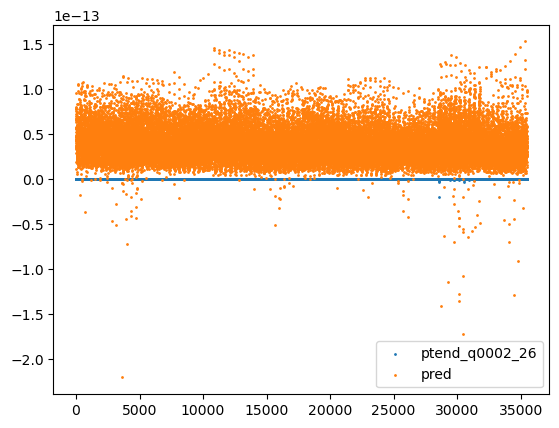

In [23]:
plt.scatter(x=range(val[targetF].shape[0]),y=val[targetF], s=1,label='ptend_q0002_26')
plt.scatter(x=range(val[targetF].shape[0]),y=predC, s=1,label='pred')
plt.legend()
plt.show()